<a target="_blank" href="https://colab.research.google.com/github/charecktowa/Chemistry-ML/blob/paper/paper/wine.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [50]:
# @title
import warnings

warnings.filterwarnings("ignore")

In [51]:
# set seeds for reproducibility
import random
import numpy as np
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_wine

# Configure plot style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Load wine dataset
wine = load_wine()

# Convert to pandas DataFrame for easier analysis
df = pd.DataFrame(wine.data, columns=wine.feature_names)
df["target"] = wine.target


# Map to more descriptive names
# Note: We use generic names since the specific varieties in the original dataset
# don't correspond exactly to known grape varieties
varieties = {0: "Barolo", 1: "Grignolino", 2: "Barbera"}
df["Variety"] = df["target"].map(varieties)  
wine.target_names = [varieties[i] for i in range(len(varieties))]


# Basic dataset information
print("INITIAL DATASET ANALYSIS")
print("=" * 50)
print(f"Total samples analyzed: {len(df)}")
print(f"Chemical variables measured: {len(wine.feature_names)}")
print(f"Number of varieties: {len(varieties)}")

INITIAL DATASET ANALYSIS
Total samples analyzed: 178
Chemical variables measured: 13
Number of varieties: 3


In [53]:
# @title
import numpy as np

# Configuración mejorada para visualizaciones
sns.set(style="whitegrid", palette="husl", font_scale=1.2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "sans-serif"

# Paleta de colores consistente
colores = ["#2E86AB", "#A23B72", "#F18F01"]  # Azul, púrpura, naranja

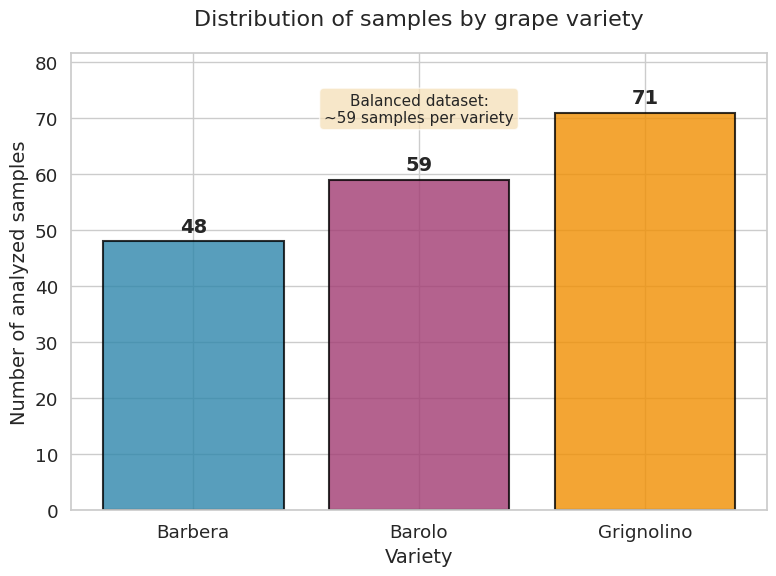

The balanced distribution is important to prevent the model
from developing biases toward any specific variety.



In [54]:
# @title
import numpy as np

# Enhanced visualization settings
sns.set(style="whitegrid", palette="husl", font_scale=1.2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "sans-serif"

# Consistent color palette
colors = ["#2E86AB", "#A23B72", "#F18F01"]  # Blue, purple, orange

# @title
# 1. Distribution of samples by variety
plt.figure(figsize=(8, 6))
count = df["Variety"].value_counts().sort_index()

bars = plt.bar(
    count.index,
    count.values,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)

# Add values on top of bars
for i, (variety, quantity) in enumerate(count.items()):
    plt.text(
        i,
        quantity + 1,
        str(quantity),
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

plt.title("Distribution of samples by grape variety", fontsize=16, pad=20)
plt.xlabel("Variety", fontsize=14)
plt.ylabel("Number of analyzed samples", fontsize=14)
plt.ylim(0, max(count.values) * 1.15)

# Add information about balance
plt.text(
    1,
    max(count.values) * 1.05,
    f"Balanced dataset:\n~{count.mean():.0f} samples per variety",
    ha="center",
    va="top",
    fontsize=11,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.7),
)

plt.tight_layout()
plt.show()

print("The balanced distribution is important to prevent the model")
print("from developing biases toward any specific variety.\n")

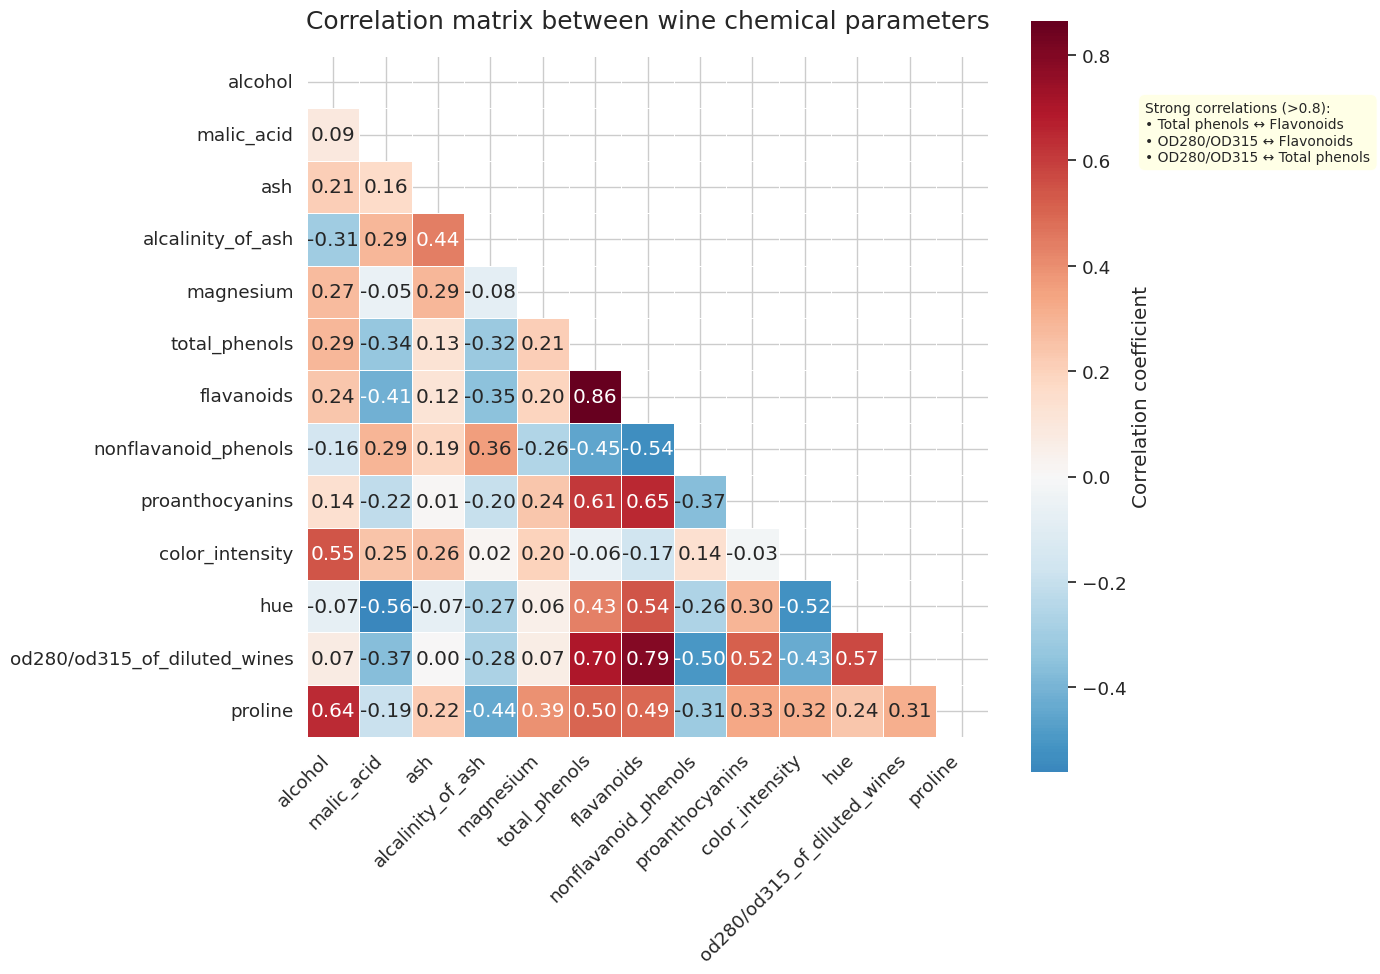

In [55]:
# @title
# 2. Correlation matrix with chemical interpretation
plt.figure(figsize=(14, 12))

# Calculate correlation
corr = df.drop(columns=["target", "Variety"]).corr()  # Updated column name

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create heatmap
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Correlation coefficient"},
)

plt.title("Correlation matrix between wine chemical parameters", fontsize=18, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Add annotations about important correlations
plt.text(
    16,
    2,
    "Strong correlations (>0.8):\n• Total phenols ↔ Flavonoids\n• OD280/OD315 ↔ Flavonoids\n• OD280/OD315 ↔ Total phenols",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8),
)

plt.tight_layout()
plt.show()

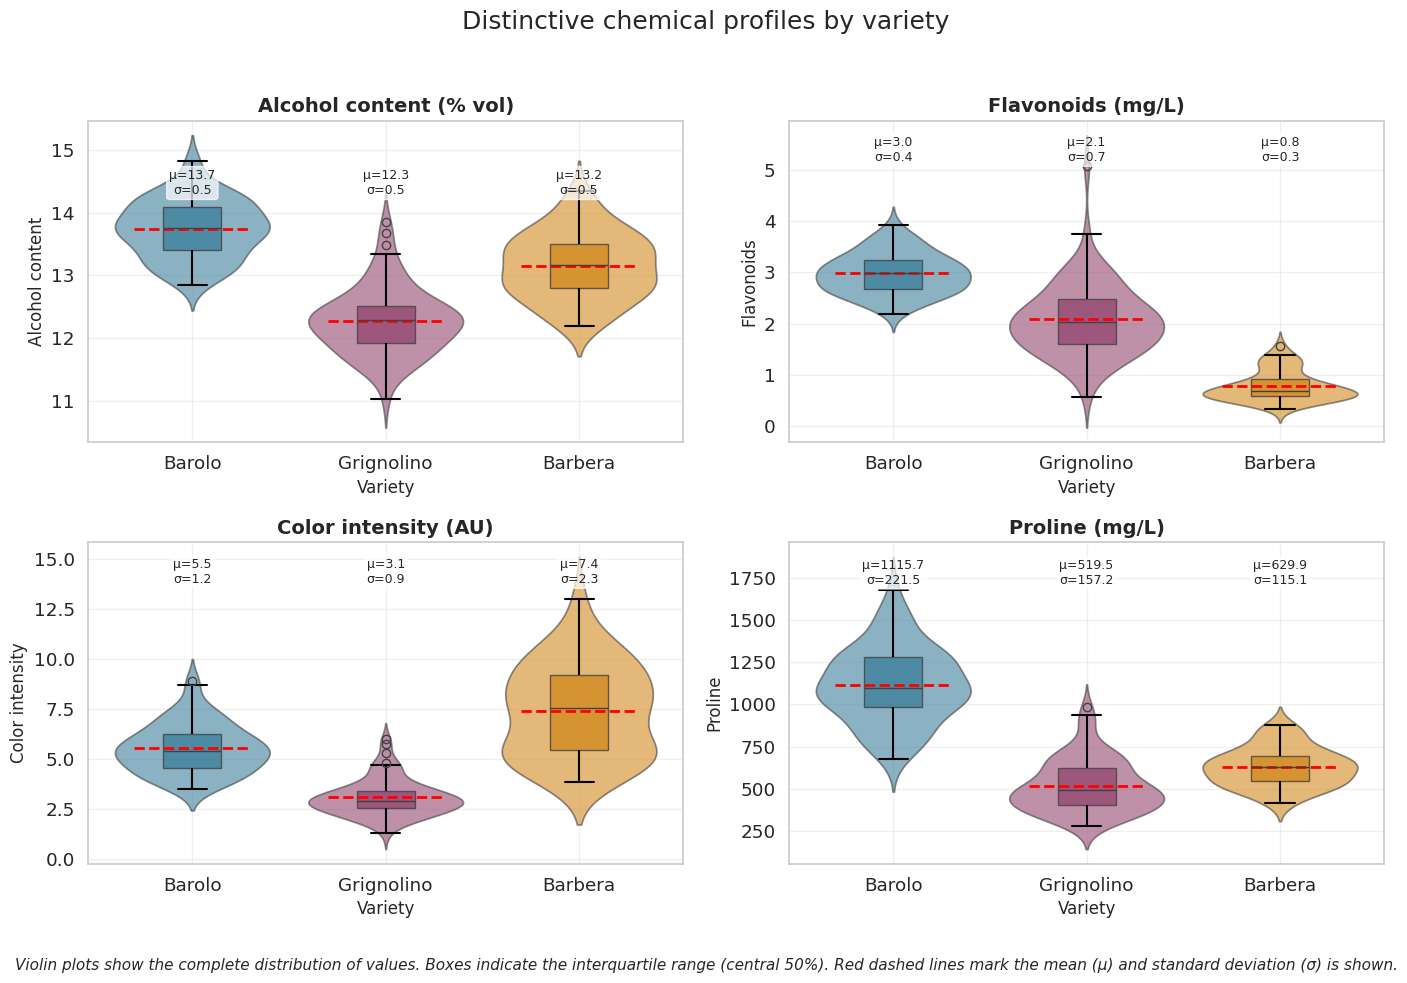

Notice how each variety has distinctive 'chemical fingerprints':
- Some differences are subtle (require statistical analysis)
- Others are more evident (clear separation between distributions)
- This justifies using machine learning for automatic classification



In [56]:
# @title
# 3. Analysis of distinctive features by variety
# Select 4 key chemical variables for comparison
key_features = {
    "alcohol": "Alcohol content (% vol)",
    "flavanoids": "Flavonoids (mg/L)",
    "color_intensity": "Color intensity (AU)",
    "proline": "Proline (mg/L)",
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, (column, full_name) in enumerate(key_features.items()):
    # Violin plot + box plot
    sns.violinplot(
        data=df,
        x="Variety",
        y=column,
        ax=axs[i],
        palette=colors,
        alpha=0.6,
        inner=None,
    )
    sns.boxplot(
        data=df,
        x="Variety",
        y=column,
        ax=axs[i],
        palette=colors,
        width=0.3,
        boxprops=dict(alpha=0.8),
        capprops=dict(color="black", linewidth=1.5),
        whiskerprops=dict(color="black", linewidth=1.5),
    )

    axs[i].set_title(full_name, fontsize=14, fontweight="bold")
    axs[i].set_xlabel("Variety", fontsize=12)
    axs[i].set_ylabel(full_name.split("(")[0].strip(), fontsize=12)
    axs[i].grid(True, alpha=0.3)

    # Add mean lines
    for j, variety in enumerate(["Barolo", "Grignolino", "Barbera"]):
        subset = df[df["Variety"] == variety][column]
        mean = subset.mean()
        std = subset.std()
        axs[i].hlines(
            mean, j - 0.3, j + 0.3, colors="red", linestyles="--", linewidth=2
        )

        # Display statistics
        axs[i].text(
            j,
            axs[i].get_ylim()[1] * 0.95,
            f"μ={mean:.1f}\nσ={std:.1f}",
            ha="center",
            va="top",
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7),
        )

plt.suptitle("Distinctive chemical profiles by variety", fontsize=18, y=0.98)
plt.figtext(
    0.5,
    0.02,
    "Violin plots show the complete distribution of values. "
    "Boxes indicate the interquartile range (central 50%). "
    "Red dashed lines mark the mean (μ) and standard deviation (σ) is shown.",
    ha="center",
    fontsize=11,
    style="italic",
)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

print("Notice how each variety has distinctive 'chemical fingerprints':")
print("- Some differences are subtle (require statistical analysis)")
print("- Others are more evident (clear separation between distributions)")
print("- This justifies using machine learning for automatic classification\n")

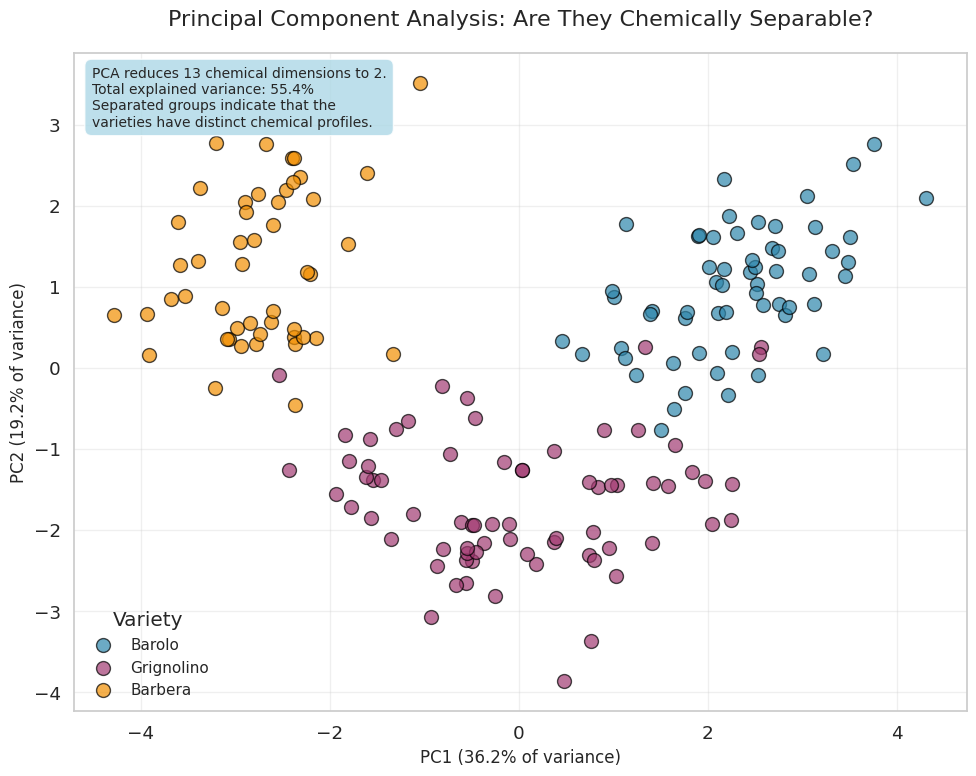

PCA confirms that the varieties are chemically separable.
This means a neural network should be able to learn
to distinguish them based on their chemical profiles.

We are now ready to build our classification model.


In [57]:
# @title
# 4. Separability Analysis using PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Prepare data
X = df.drop(columns=["target", "Variety"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame with results
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Variety"] = df["Variety"].values

# Visualize
plt.figure(figsize=(10, 8))
for i, variety in enumerate(["Barolo", "Grignolino", "Barbera"]):
    mask = df_pca["Variety"] == variety
    plt.scatter(
        df_pca[mask]["PC1"],
        df_pca[mask]["PC2"],
        c=colors[i],
        label=variety,
        s=100,
        alpha=0.7,
        edgecolors="black",
        linewidth=1,
    )

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} of variance)", fontsize=12)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} of variance)", fontsize=12)
plt.title(
    "Principal Component Analysis: Are They Chemically Separable?",
    fontsize=16,
    pad=20,
)
plt.legend(title="Variety", loc="best", fontsize=11)
plt.grid(True, alpha=0.3)

# Explanatory information
plt.text(
    0.02,
    0.98,
    f"PCA reduces {len(X.columns)} chemical dimensions to 2.\n"
    f"Total explained variance: {sum(pca.explained_variance_ratio_):.1%}\n"
    f"Separated groups indicate that the\nvarieties have distinct chemical profiles.",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8),
)

plt.tight_layout()
plt.show()

print("PCA confirms that the varieties are chemically separable.")
print("This means a neural network should be able to learn")
print("to distinguish them based on their chemical profiles.")
print("\nWe are now ready to build our classification model.")

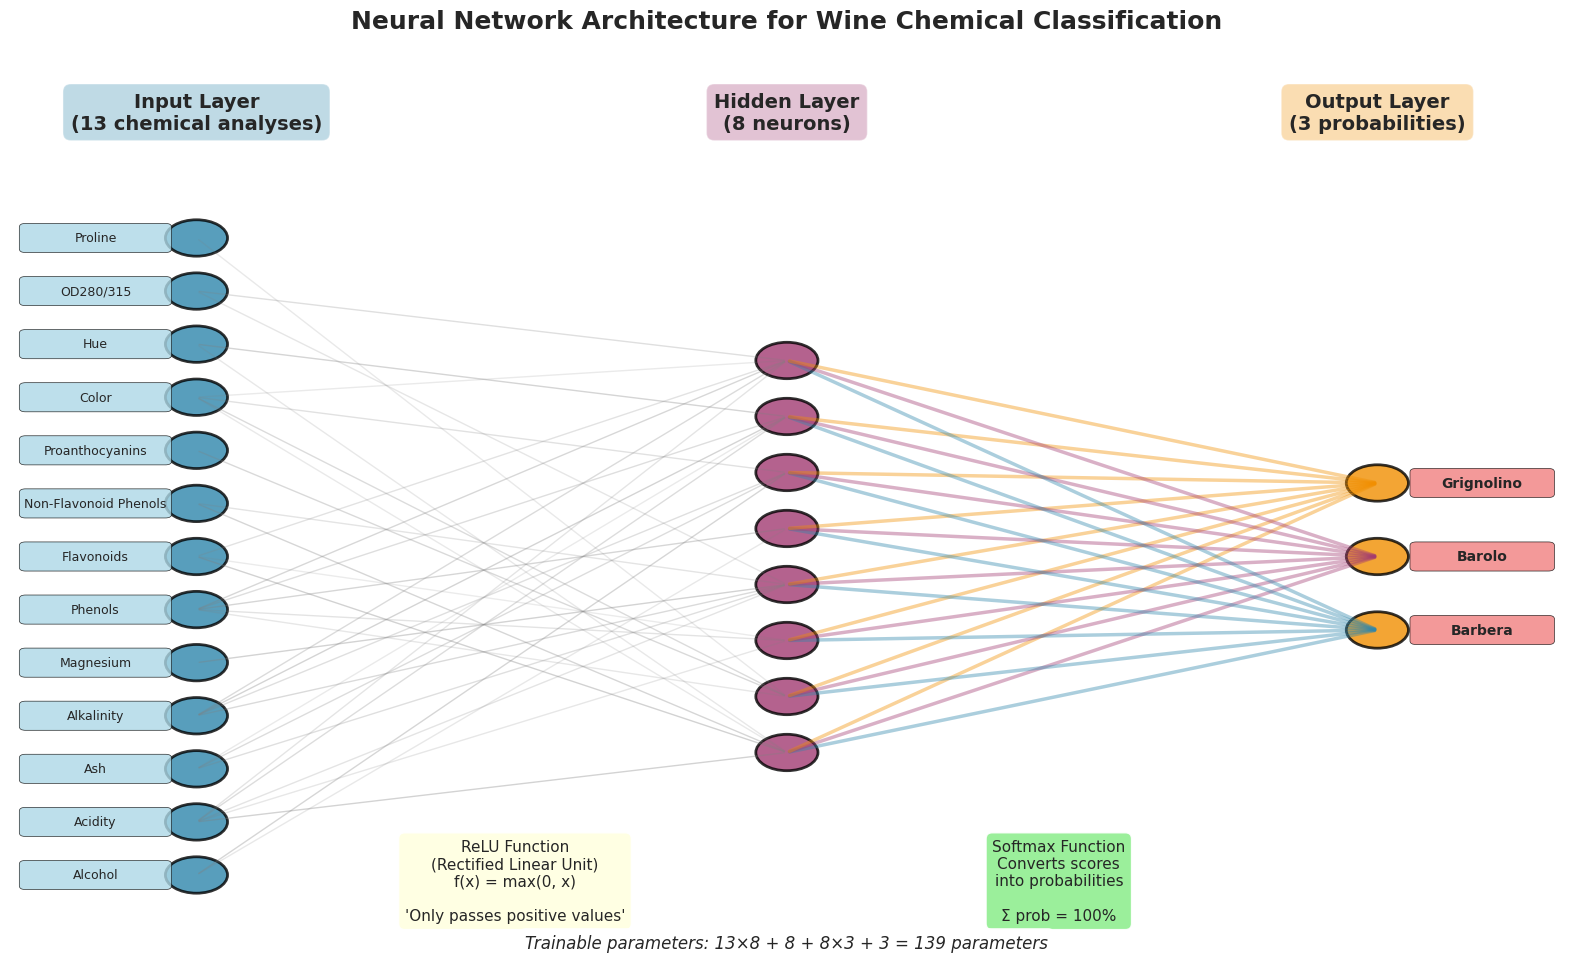

In [58]:
# @title
from matplotlib.patches import FancyBboxPatch, Circle, FancyArrowPatch


def draw_neural_network():
    """Creates a clear and educational visualization of the neural network architecture"""

    fig, ax = plt.subplots(figsize=(16, 10))

    # Position configuration with increased spacing
    layer_positions = [0.12, 0.5, 0.88]
    layer_names = [
        "Input Layer\n(13 chemical analyses)",
        "Hidden Layer\n(8 neurons)",
        "Output Layer\n(3 probabilities)",
    ]
    neuron_counts = [13, 8, 3]

    # Representative colors
    colors = ["#2E86AB", "#A23B72", "#F18F01"]  # Blue, purple, orange

    # Descriptive names for inputs (first 13)
    input_labels = [
        "Alcohol",
        "Acidity",
        "Ash",
        "Alkalinity",
        "Magnesium",
        "Phenols",
        "Flavonoids",
        "Non-Flavonoid Phenols",
        "Proanthocyanins",
        "Color",
        "Hue",
        "OD280/315",
        "Proline",
    ]

    output_labels = ["Barbera", "Barolo", "Grignolino"]

    # Calculate neuron positions
    neuron_positions = []
    max_neurons = max(neuron_counts)

    for layer_idx, (x_pos, n_neurons) in enumerate(zip(layer_positions, neuron_counts)):
        # Vertical spacing
        if n_neurons == max_neurons:
            y_positions = np.linspace(0.1, 0.8, n_neurons)
        else:
            # Center smaller layers
            total_height = 0.7
            start_y = 0.45 - (n_neurons * total_height / max_neurons) / 2
            y_positions = np.linspace(
                start_y, start_y + (n_neurons * total_height / max_neurons), n_neurons
            )

        layer_neurons = []

        # Layer title
        ax.text(
            x_pos,
            0.92,
            layer_names[layer_idx],
            ha="center",
            fontsize=14,
            fontweight="bold",
            bbox=dict(boxstyle="round,pad=0.4", facecolor=colors[layer_idx], alpha=0.3),
        )

        # Draw neurons
        for i, y_pos in enumerate(y_positions):
            # Neuron circle
            circle = Circle(
                (x_pos, y_pos),
                0.02,
                fill=True,
                color=colors[layer_idx],
                alpha=0.8,
                ec="black",
                linewidth=2,
            )
            ax.add_patch(circle)
            layer_neurons.append((x_pos, y_pos))

            # Input and output labels
            if layer_idx == 0:  # Input layer
                label_box = FancyBboxPatch(
                    (x_pos - 0.11, y_pos - 0.012),
                    0.09,
                    0.024,
                    boxstyle="round,pad=0.004",
                    facecolor="lightblue",
                    alpha=0.8,
                    ec="black",
                    linewidth=0.5,
                )
                ax.add_patch(label_box)
                ax.text(
                    x_pos - 0.065,
                    y_pos,
                    input_labels[i],
                    ha="center",
                    va="center",
                    fontsize=9,
                    fontweight="normal",
                )

            elif layer_idx == 2:  # Output layer
                label_box = FancyBboxPatch(
                    (x_pos + 0.025, y_pos - 0.012),
                    0.085,
                    0.024,
                    boxstyle="round,pad=0.004",
                    facecolor="lightcoral",
                    alpha=0.8,
                    ec="black",
                    linewidth=0.5,
                )
                ax.add_patch(label_box)
                ax.text(
                    x_pos + 0.0675,
                    y_pos,
                    output_labels[i],
                    ha="center",
                    va="center",
                    fontsize=10,
                    fontweight="bold",
                )

        neuron_positions.append(layer_neurons)

    # Draw connections
    # Input → Hidden layer (only some for clarity)
    np.random.seed(42)  # For reproducibility
    for i, start_pos in enumerate(neuron_positions[0]):
        for j, end_pos in enumerate(neuron_positions[1]):
            # Show only select connections to avoid clutter
            if np.random.random() < 0.3:  # 30% of connections
                alpha = 0.15 + np.random.random() * 0.2
                line = FancyArrowPatch(
                    start_pos,
                    end_pos,
                    connectionstyle="arc3,rad=0",
                    arrowstyle="-",
                    lw=1,
                    alpha=alpha,
                    color="gray",
                )
                ax.add_patch(line)

    # Hidden layer → Output (all connections)
    for start_pos in neuron_positions[1]:
        for j, end_pos in enumerate(neuron_positions[2]):
            # Color by output class
            connection_color = colors[j]
            line = FancyArrowPatch(
                start_pos,
                end_pos,
                connectionstyle="arc3,rad=0",
                arrowstyle="-",
                lw=2.5,
                alpha=0.4,
                color=connection_color,
            )
            ax.add_patch(line)

    # Activation function information
    ax.text(
        0.325,
        0.05,
        "ReLU Function\n(Rectified Linear Unit)\nf(x) = max(0, x)\n\n'Only passes positive values'",
        fontsize=11,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.9),
    )

    ax.text(
        0.675,
        0.05,
        "Softmax Function\nConverts scores\ninto probabilities\n\nΣ prob = 100%",
        fontsize=11,
        ha="center",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgreen", alpha=0.9),
    )

    # Parameter information
    ax.text(
        0.5,
        0.02,
        "Trainable parameters: 13×8 + 8 + 8×3 + 3 = 139 parameters",
        fontsize=12,
        ha="center",
        style="italic",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

    # Final configuration
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis("off")
    ax.set_title(
        "Neural Network Architecture for Wine Chemical Classification",
        fontsize=18,
        pad=20,
        fontweight="bold",
    )

    plt.tight_layout()
    plt.show()


# Create the visualization
draw_neural_network()

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class WineClassifier(nn.Module):
    """
    Neural network for classifying wine based on chemical analysis.

    A simple yet effective architecture:
    - Input: 13 chemical parameters
    - Hidden layer: 8 neurons with ReLU activation
    - Output: 3 scores (one per grape variety)

    Think of it as designing an automated analytical protocol.
    """

    def __init__(self):
        super(WineClassifier, self).__init__()

        # Define the "reaction stages" in our network.
        # nn.Linear applies a linear transformation: output = input × weight + bias

        # First reaction: 13 chemical features → 8 intermediate characteristics
        self.analysis_layer = nn.Linear(in_features=13, out_features=8)

        # Second reaction: 8 features → 3 final class scores
        self.classification_layer = nn.Linear(in_features=8, out_features=3)

    def forward(self, chemical_data):
        """
        Defines the forward pass through the network.
        It simulates the steps of a chemical analysis.

        Parameters:
        - chemical_data: tensor of shape [batch_size, 13] representing chemical measurements

        Returns:
        - Raw scores for each wine variety (before softmax)
        """

        # Step 1: Process the input chemical data
        features = self.analysis_layer(chemical_data)

        # Step 2: Apply ReLU activation
        # ReLU(x) = max(0, x), filters out negative signals
        features = F.relu(features)

        # Step 3: Generate class scores for each variety
        scores = self.classification_layer(features)

        # Note: We do NOT apply softmax here because PyTorch's CrossEntropyLoss
        # expects raw scores (logits) and applies softmax internally

        return scores

In [60]:
# Crear model instance
model = WineClassifier()

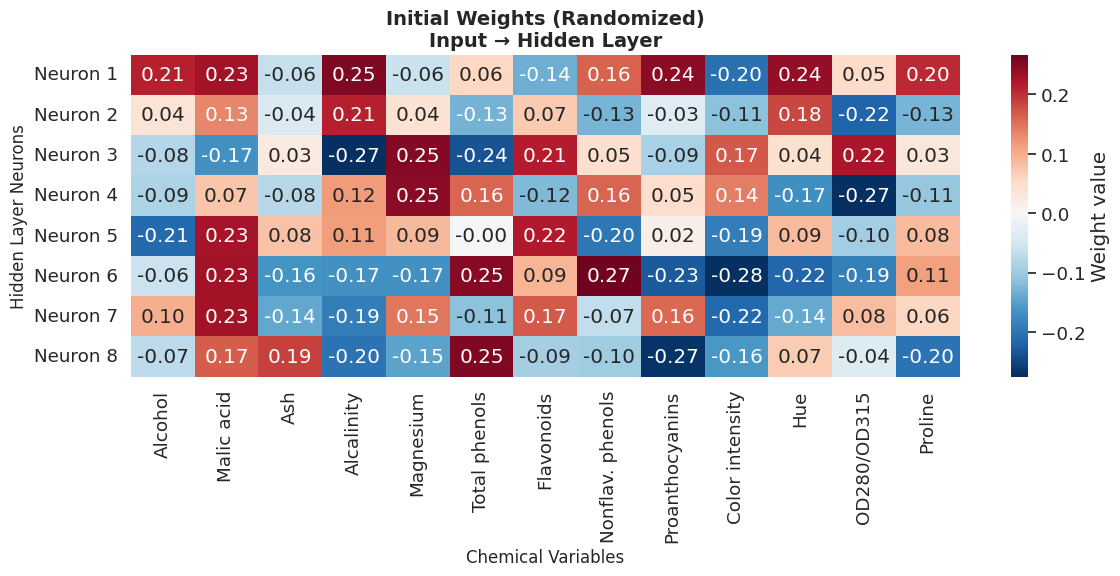

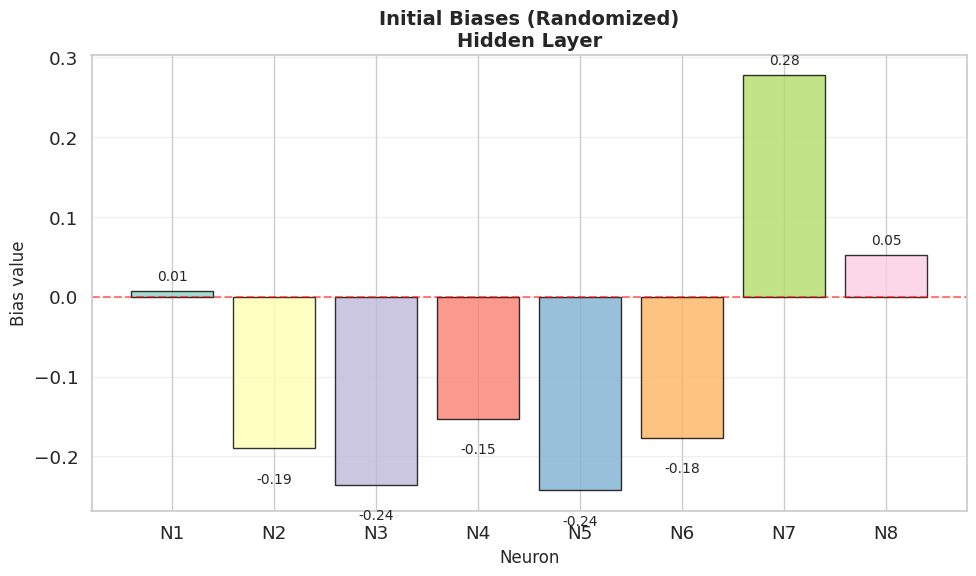

In [61]:
# Get the initial weights and biases of the first layer
initial_weights = model.analysis_layer.weight.data.numpy()
initial_biases = model.analysis_layer.bias.data.numpy()

# Descriptive names for the 13 chemical features
chemical_features = [
    "Alcohol",
    "Malic acid",
    "Ash",
    "Alcalinity",
    "Magnesium",
    "Total phenols",
    "Flavonoids",
    "Nonflav. phenols",
    "Proanthocyanins",
    "Color intensity",
    "Hue",
    "OD280/OD315",
    "Proline",
]

fig1, ax1 = plt.subplots(figsize=(12, 6))

sns.heatmap(
    initial_weights,
    cmap="RdBu_r",
    center=0,
    xticklabels=chemical_features,
    yticklabels=[f"Neuron {i+1}" for i in range(8)],
    cbar_kws={"label": "Weight value"},
    annot=True,
    fmt=".2f",
    ax=ax1,
)

ax1.set_title(
    "Initial Weights (Randomized)\nInput → Hidden Layer", fontsize=14, fontweight="bold"
)
ax1.set_xlabel("Chemical Variables", fontsize=12)
ax1.set_ylabel("Hidden Layer Neurons", fontsize=12)

plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 6))

# Color map for bars
neuron_colors = plt.cm.Set3(np.arange(8))

bars = ax2.bar(
    range(8),
    initial_biases,
    color=neuron_colors,
    edgecolor="black",
    linewidth=1,
    alpha=0.8,
)

ax2.set_title(
    "Initial Biases (Randomized)\nHidden Layer", fontsize=14, fontweight="bold"
)
ax2.set_xlabel("Neuron", fontsize=12)
ax2.set_ylabel("Bias value", fontsize=12)
ax2.set_xticks(range(8))
ax2.set_xticklabels([f"N{i+1}" for i in range(8)])
ax2.grid(True, alpha=0.3, axis="y")
ax2.axhline(y=0, color="red", linestyle="--", alpha=0.5)

# Add value labels on top of each bar
for bar, value in zip(bars, initial_biases):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.01 if height >= 0 else height - 0.03,
        f"{value:.2f}",
        ha="center",
        va="bottom" if height >= 0 else "top",
        fontsize=10,
    )

plt.tight_layout()
plt.show()

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import numpy as np
import time

# Step 1: Prepare the data
print("DATA PREPARATION FOR TRAINING")
print("=" * 50)

# Separate features (X) and labels (y)
X = wine.data  # 13 chemical measurements per sample
y = wine.target  # Wine variety labels (0, 1, 2)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% for testing
    random_state=42,  # For reproducibility
    stratify=y,  # Maintain class proportions
)

print("Data split completed:")
print(f"  • Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  • Test set:     {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

DATA PREPARATION FOR TRAINING
Data split completed:
  • Training set: 142 samples (79.8%)
  • Test set:     36 samples (20.2%)


In [63]:
# Check class balance in training set
print(f"\nDistribution in training set:")
varieties_map = {0: "Barolo", 1: "Grignolino", 2: "Barbera"}

for i in range(3):
    count = np.sum(y_train == i)
    print(f"  • {varieties_map[i]}: {count} samples")


Distribution in training set:
  • Barolo: 47 samples
  • Grignolino: 57 samples
  • Barbera: 38 samples


In [64]:
# Step 2: Critical standardization
print(f"\nSTANDARDIZATION OF CHEMICAL VARIABLES:")
print("-" * 30)

# Create and fit the scaler ONLY on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Only transform, do not refit

# Show the effect of standardization on the 'Alcohol' feature (column 0)
print("Example using alcohol content:")
print(f"  • Before: range {X_train[:, 0].min():.2f} - {X_train[:, 0].max():.2f}")
print(
    f"  • After:  range {X_train_scaled[:, 0].min():.2f} - {X_train_scaled[:, 0].max():.2f}"
)
print(f"  • Mean after: {X_train_scaled[:, 0].mean():.3f} (≈ 0)")
print(f"  • Std. deviation after: {X_train_scaled[:, 0].std():.3f} (≈ 1)")


STANDARDIZATION OF CHEMICAL VARIABLES:
------------------------------
Example using alcohol content:
  • Before: range 11.03 - 14.83
  • After:  range -2.43 - 2.32
  • Mean after: 0.000 (≈ 0)
  • Std. deviation after: 1.000 (≈ 1)


In [65]:
import torch

# Step 3: Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test)

# Step 4: Create DataLoader for mini-batch training
batch_size = 64  # Process 64 samples at a time
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [66]:
# 5. Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
import torch.nn.functional as F

# Step 6: Training configuration
num_epochs = 100

# Lists to track progress
train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []


def compute_accuracy(model, X, y):
    """Helper function to compute accuracy"""
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y).sum().item()
        accuracy = correct / len(y) * 100
    return accuracy


# Start timer
start_time = time.time()

# Main training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    # Process each batch
    for batch_X, batch_y in train_loader:
        # 1. Clear previous gradients
        optimizer.zero_grad()

        # 2. Forward pass
        predictions = model(batch_X)

        # 3. Compute loss
        loss = criterion(predictions, batch_y)

        # 4. Backpropagation
        loss.backward()

        # 5. Update weights
        optimizer.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)

    # Evaluate on both sets
    train_accuracy = compute_accuracy(model, X_train_tensor, y_train_tensor)
    test_accuracy = compute_accuracy(model, X_test_tensor, y_test_tensor)

    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    # Compute loss on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_loss_history.append(test_loss)

    # Print progress every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs}:")
        print(f"  • Training loss:   {avg_loss:.4f}")
        print(f"  • Test loss:       {test_loss:.4f}")
        print(f"  • Train accuracy:  {train_accuracy:.1f}%")
        print(f"  • Test accuracy:   {test_accuracy:.1f}%")
        print()

Epoch  20/100:
  • Training loss:   0.0495
  • Test loss:       0.0615
  • Train accuracy:  98.6%
  • Test accuracy:   100.0%

Epoch  40/100:
  • Training loss:   0.0107
  • Test loss:       0.0426
  • Train accuracy:  100.0%
  • Test accuracy:   97.2%

Epoch  60/100:
  • Training loss:   0.0049
  • Test loss:       0.0374
  • Train accuracy:  100.0%
  • Test accuracy:   97.2%

Epoch  80/100:
  • Training loss:   0.0029
  • Test loss:       0.0385
  • Train accuracy:  100.0%
  • Test accuracy:   97.2%

Epoch 100/100:
  • Training loss:   0.0019
  • Test loss:       0.0384
  • Train accuracy:  100.0%
  • Test accuracy:   97.2%



In [68]:
total_time = time.time() - start_time

print("TRAINING COMPLETE")
print("=" * 50)
print(f"Total training time: {total_time:.1f} seconds")
print(f"Final training accuracy: {train_accuracy_history[-1]:.1f}%")
print(f"Final test accuracy:     {test_accuracy_history[-1]:.1f}%")
print(f"Final test loss:         {test_loss_history[-1]:.4f}")

# Interpret results
if test_accuracy_history[-1] > 95:
    print("\nExcellent! The model learned to classify wines with very high accuracy.")
elif test_accuracy_history[-1] > 85:
    print("\nVery good! The model performs well on the classification task.")
elif test_accuracy_history[-1] > 70:
    print(
        "\nDecent result. The model learned useful patterns, but there's room for improvement."
    )
else:
    print(
        "\nThe model needs adjustments. Consider changing the architecture or hyperparameters."
    )

# Baseline comparison
print(
    f"\nComparison with random guessing: {test_accuracy_history[-1]:.1f}% vs 33.3% (random)"
)
print(f"Improvement over chance: {test_accuracy_history[-1]/33.3:.1f}×")

TRAINING COMPLETE
Total training time: 0.5 seconds
Final training accuracy: 100.0%
Final test accuracy:     97.2%
Final test loss:         0.0384

Excellent! The model learned to classify wines with very high accuracy.

Comparison with random guessing: 97.2% vs 33.3% (random)
Improvement over chance: 2.9×


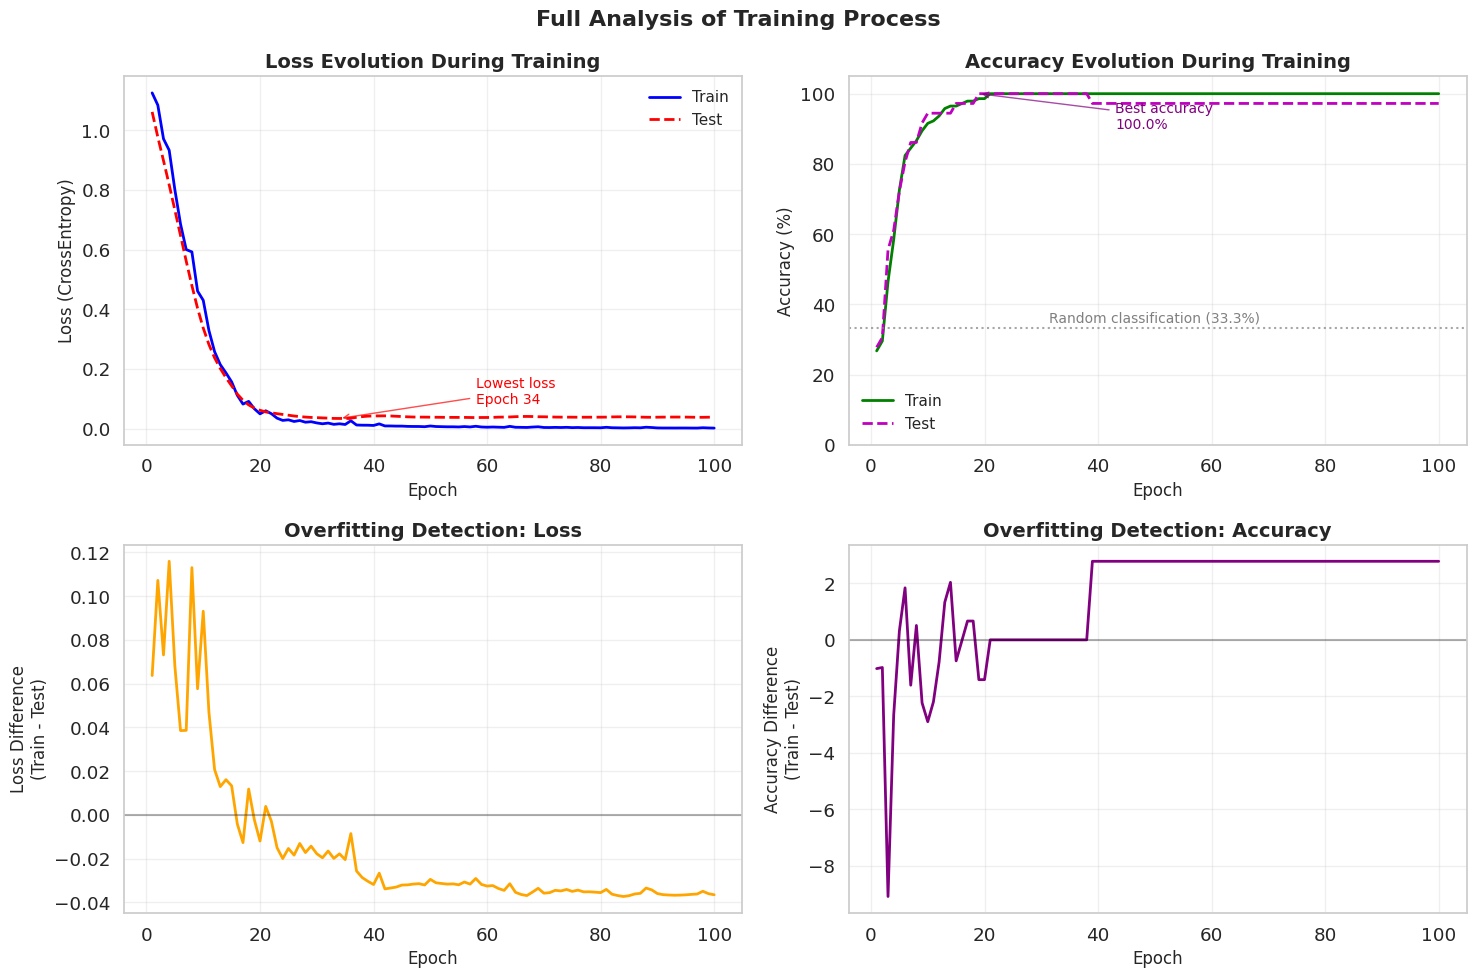

TRAINING PROCESS ANALYSIS
✓ CONVERGENCE: Test loss has stabilized (good sign)
✓ GOOD BALANCE: Normal differences between training and test performance

LEARNING SPEED:
• Improvement in first 20 epochs: 72.2%
• Improvement in last 20 epochs:  0.0%
✓ Fast initial learning (good config)
✓ Final stabilization (convergence achieved)

FINAL SUMMARY:
• Max test accuracy achieved: 100.0%
• Best performance at epoch:  19
• Loss reduction: 1.062 → 0.038
• Avg. time per epoch: 0.00 seconds

EXCELLENT: 97.2% is an outstanding result for this dataset


In [69]:
# Create full visualization of training progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, num_epochs + 1)

# 1. Loss evolution
ax1.plot(epochs_range, train_loss_history, "b-", label="Train", linewidth=2)
ax1.plot(epochs_range, test_loss_history, "r--", label="Test", linewidth=2)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss (CrossEntropy)", fontsize=12)
ax1.set_title("Loss Evolution During Training", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Highlight epoch with lowest test loss
min_loss_idx = np.argmin(test_loss_history)
ax1.annotate(
    f"Lowest loss\nEpoch {min_loss_idx+1}",
    xy=(min_loss_idx + 1, test_loss_history[min_loss_idx]),
    xytext=(min_loss_idx + 25, test_loss_history[min_loss_idx] + 0.05),
    arrowprops=dict(arrowstyle="->", color="red", alpha=0.7),
    fontsize=10,
    color="red",
)

# 2. Accuracy evolution
ax2.plot(epochs_range, train_accuracy_history, "g-", label="Train", linewidth=2)
ax2.plot(epochs_range, test_accuracy_history, "m--", label="Test", linewidth=2)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Accuracy Evolution During Training", fontsize=14, fontweight="bold")
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 105)

# Baseline (random classifier)
ax2.axhline(y=33.33, color="gray", linestyle=":", alpha=0.7, label="Random guess")
ax2.text(
    num_epochs / 2,
    35,
    "Random classification (33.3%)",
    ha="center",
    fontsize=10,
    color="gray",
)

# Highlight epoch with highest accuracy
max_acc_idx = np.argmax(test_accuracy_history)
ax2.annotate(
    f"Best accuracy\n{test_accuracy_history[max_acc_idx]:.1f}%",
    xy=(max_acc_idx + 1, test_accuracy_history[max_acc_idx]),
    xytext=(max_acc_idx + 25, test_accuracy_history[max_acc_idx] - 10),
    arrowprops=dict(arrowstyle="->", color="purple", alpha=0.7),
    fontsize=10,
    color="purple",
)

# 3. Overfitting detection – loss difference
loss_gap = np.array(train_loss_history) - np.array(test_loss_history)
acc_gap = np.array(train_accuracy_history) - np.array(test_accuracy_history)

ax3.plot(epochs_range, loss_gap, "orange", linewidth=2)
ax3.set_xlabel("Epoch", fontsize=12)
ax3.set_ylabel("Loss Difference\n(Train - Test)", fontsize=12)
ax3.set_title("Overfitting Detection: Loss", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color="black", linestyle="-", alpha=0.3)

if np.any(loss_gap < -0.1):
    ax3.fill_between(
        epochs_range,
        loss_gap,
        -0.1,
        where=(loss_gap < -0.1),
        alpha=0.3,
        color="red",
        label="Possible overfitting",
    )
    ax3.legend()

# 4. Overfitting detection – accuracy difference
ax4.plot(epochs_range, acc_gap, "purple", linewidth=2)
ax4.set_xlabel("Epoch", fontsize=12)
ax4.set_ylabel("Accuracy Difference\n(Train - Test)", fontsize=12)
ax4.set_title("Overfitting Detection: Accuracy", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0, color="black", linestyle="-", alpha=0.3)

if np.any(acc_gap > 10):
    ax4.fill_between(
        epochs_range,
        acc_gap,
        10,
        where=(acc_gap > 10),
        alpha=0.3,
        color="red",
        label="Possible overfitting",
    )
    ax4.legend()

plt.suptitle("Full Analysis of Training Process", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

# Textual analysis of training
print("TRAINING PROCESS ANALYSIS")
print("=" * 50)

# Convergence check
final_10_loss = np.mean(test_loss_history[-10:])
middle_10_loss = np.mean(test_loss_history[-20:-10])
if abs(final_10_loss - middle_10_loss) < 0.01:
    print("✓ CONVERGENCE: Test loss has stabilized (good sign)")
else:
    print("Loss is still fluctuating (more epochs may help)")

# Overfitting check
final_acc_gap = acc_gap[-1]
if final_acc_gap > 15:
    print("OVERFITTING DETECTED: Large gap between train and test accuracy")
    print("  Recommendation: Apply regularization or reduce epochs")
elif final_acc_gap > 5:
    print("MILD OVERFITTING: Moderate gap between train and test accuracy")
else:
    print("✓ GOOD BALANCE: Normal differences between training and test performance")

# Learning speed
initial_improvement = test_accuracy_history[19] - test_accuracy_history[0]
final_improvement = test_accuracy_history[-1] - test_accuracy_history[-21]

print(f"\nLEARNING SPEED:")
print(f"• Improvement in first 20 epochs: {initial_improvement:.1f}%")
print(f"• Improvement in last 20 epochs:  {final_improvement:.1f}%")

if initial_improvement > 30:
    print("✓ Fast initial learning (good config)")
if abs(final_improvement) < 2:
    print("✓ Final stabilization (convergence achieved)")

# Final summary
print(f"\nFINAL SUMMARY:")
print(f"• Max test accuracy achieved: {max(test_accuracy_history):.1f}%")
print(f"• Best performance at epoch:  {np.argmax(test_accuracy_history)+1}")
print(f"• Loss reduction: {test_loss_history[0]:.3f} → {test_loss_history[-1]:.3f}")
print(f"• Avg. time per epoch: {total_time/num_epochs:.2f} seconds")

# Benchmark comparison
final_acc = test_accuracy_history[-1]
if final_acc > 95:
    print(f"\nEXCELLENT: {final_acc:.1f}% is an outstanding result for this dataset")
elif final_acc > 90:
    print(f"\nVERY GOOD: {final_acc:.1f}% shows effective learning")
elif final_acc > 80:
    print(f"\nGOOD: {final_acc:.1f}% is a solid result, clearly above random")
else:
    print(
        f"\nIMPROVEMENT NEEDED: {final_acc:.1f}% suggests tuning the architecture or hyperparameters"
    )

In [70]:
# Generate model predictions on the test set
model.eval()
with torch.no_grad():
    outputs_test = model(X_test_tensor)
    probabilities = torch.softmax(
        outputs_test, dim=1
    ).numpy()  # Convert logits to probabilities
    _, predictions = torch.max(outputs_test, dim=1)
    predictions = predictions.numpy()

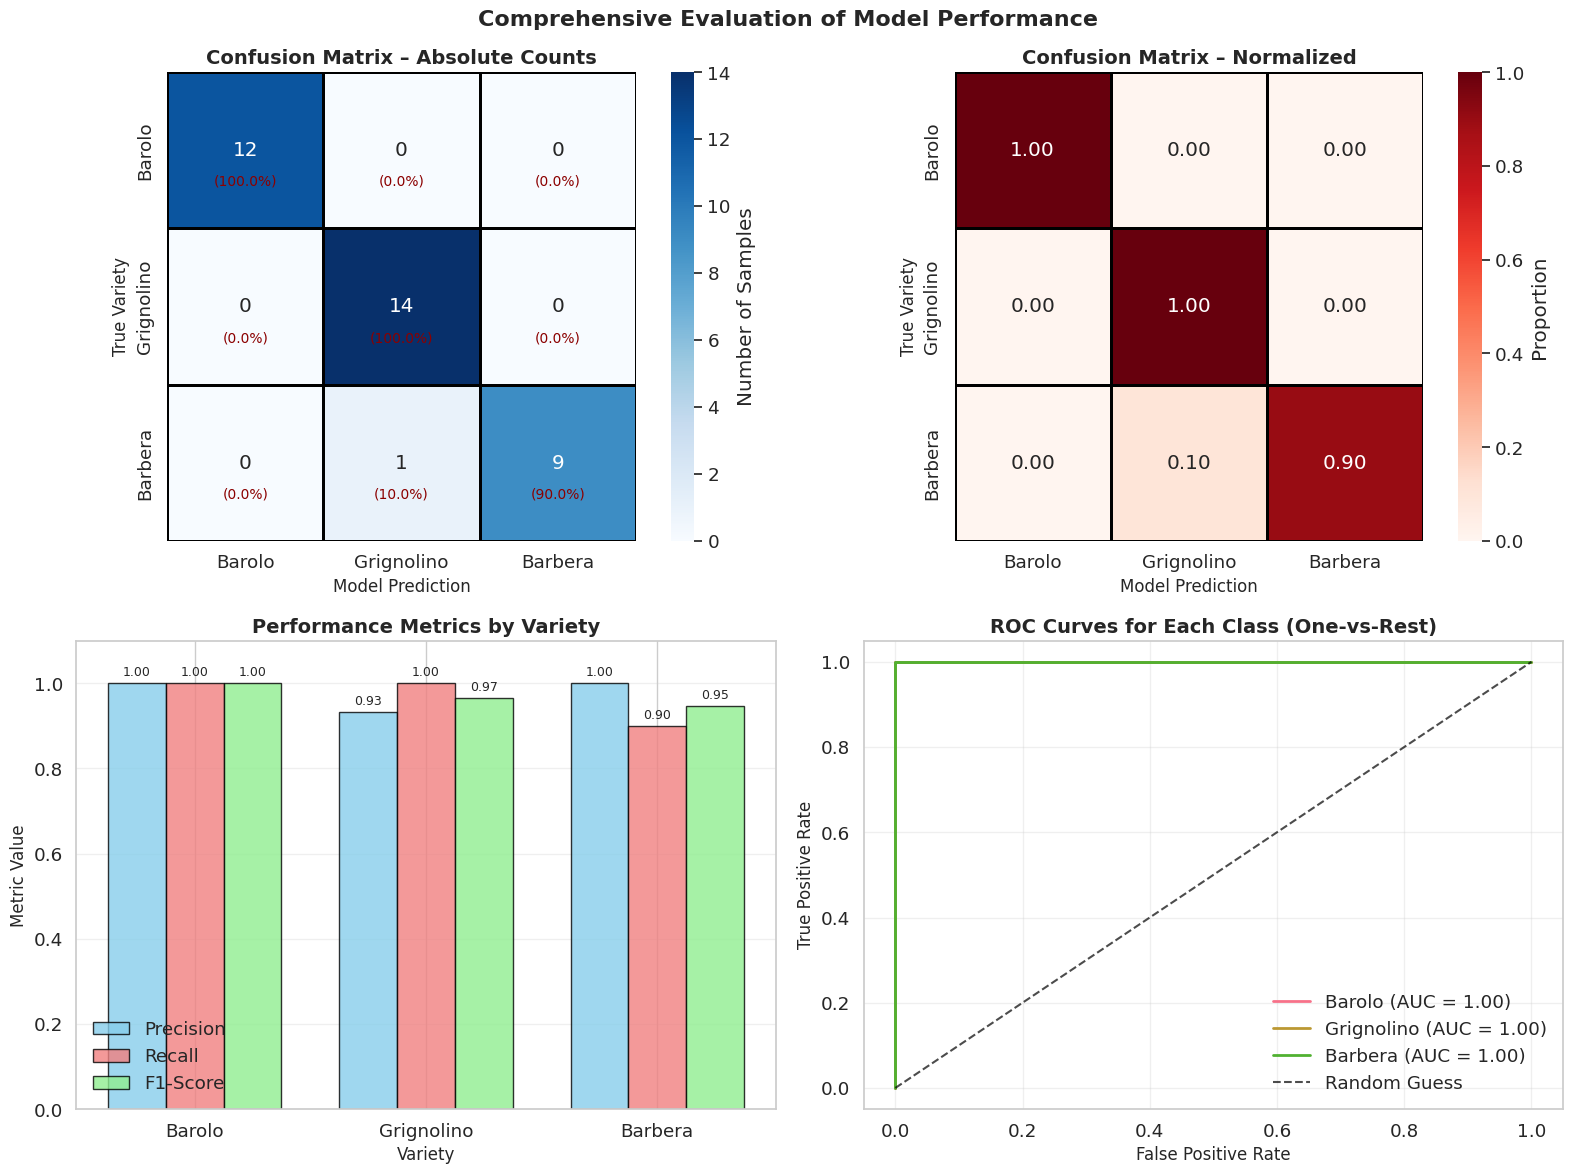

In [71]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
class_names = ["Barolo", "Grignolino", "Barbera"]

# Create complete visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion matrix – absolute numbers
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Number of Samples"},
    square=True,
    linewidths=1,
    linecolor="black",
    ax=ax1,
)

# Add percentage annotations
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i].sum() > 0:
            pct = conf_matrix[i, j] / conf_matrix[i].sum() * 100
            ax1.text(
                j + 0.5,
                i + 0.7,
                f"({pct:.1f}%)",
                ha="center",
                va="center",
                fontsize=10,
                color="darkred",
            )

ax1.set_title("Confusion Matrix – Absolute Counts", fontsize=14, fontweight="bold")
ax1.set_xlabel("Model Prediction", fontsize=12)
ax1.set_ylabel("True Variety", fontsize=12)

# 2. Normalized confusion matrix
normalized_matrix = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    normalized_matrix,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Proportion"},
    square=True,
    linewidths=1,
    linecolor="black",
    ax=ax2,
)

ax2.set_title("Confusion Matrix – Normalized", fontsize=14, fontweight="bold")
ax2.set_xlabel("Model Prediction", fontsize=12)
ax2.set_ylabel("True Variety", fontsize=12)

# 3. Per-class metrics
metrics_by_class = []
for i, variety in enumerate(class_names):
    tp = conf_matrix[i, i]
    fp = conf_matrix[:, i].sum() - tp
    fn = conf_matrix[i, :].sum() - tp

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (
        2 * (precision * recall) / (precision + recall)
        if (precision + recall) > 0
        else 0
    )

    metrics_by_class.append(
        {
            "variety": variety,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "samples": conf_matrix[i].sum(),
        }
    )

# Visualize metrics
x_pos = np.arange(len(class_names))
width = 0.25

prec_vals = [m["precision"] for m in metrics_by_class]
recall_vals = [m["recall"] for m in metrics_by_class]
f1_vals = [m["f1"] for m in metrics_by_class]

bars1 = ax3.bar(
    x_pos - width,
    prec_vals,
    width,
    label="Precision",
    color="skyblue",
    edgecolor="black",
    alpha=0.8,
)
bars2 = ax3.bar(
    x_pos,
    recall_vals,
    width,
    label="Recall",
    color="lightcoral",
    edgecolor="black",
    alpha=0.8,
)
bars3 = ax3.bar(
    x_pos + width,
    f1_vals,
    width,
    label="F1-Score",
    color="lightgreen",
    edgecolor="black",
    alpha=0.8,
)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

ax3.set_xlabel("Variety", fontsize=12)
ax3.set_ylabel("Metric Value", fontsize=12)
ax3.set_title("Performance Metrics by Variety", fontsize=14, fontweight="bold")
ax3.set_xticks(x_pos)
ax3.set_xticklabels(class_names)
ax3.legend()
ax3.set_ylim(0, 1.1)
ax3.grid(True, alpha=0.3, axis="y")

# 4. ROC Curves (One-vs-Rest)
# Binarize true labels
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

# Compute ROC and AUC for each class
for i, variety in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    ax4.plot(fpr, tpr, lw=2, label=f"{variety} (AUC = {roc_auc:.2f})")

# Random baseline
ax4.plot([0, 1], [0, 1], "k--", label="Random Guess", alpha=0.7)

ax4.set_xlabel("False Positive Rate", fontsize=12)
ax4.set_ylabel("True Positive Rate", fontsize=12)
ax4.set_title("ROC Curves for Each Class (One-vs-Rest)", fontsize=14, fontweight="bold")
ax4.legend(loc="lower right")
ax4.grid(True, alpha=0.3)

plt.suptitle(
    "Comprehensive Evaluation of Model Performance", fontsize=16, fontweight="bold"
)
plt.tight_layout()
plt.show()

In [72]:
print("VISUALIZING HOW THE MODEL 'SEES' THE DATA")
print("=" * 55)

# To visualize, we need to reduce the 13-dimensional space to 2D
print("Preparing 2D projection...")

# Use PCA on all data (train + test) for consistency
X_all_scaled = scaler.fit_transform(np.vstack([X_train, X_test]))
y_all = np.hstack([y_train, y_test])

# Apply PCA
pca_viz = PCA(n_components=2)
X_pca_all = pca_viz.fit_transform(X_all_scaled)

# Split back into train/test
X_pca_train = X_pca_all[: len(X_train)]
X_pca_test = X_pca_all[len(X_train) :]

# Report variance explained
print("✓ Dimensionality reduction complete")
print(f"  • Variance explained by PC1: {pca_viz.explained_variance_ratio_[0]:.1%}")
print(f"  • Variance explained by PC2: {pca_viz.explained_variance_ratio_[1]:.1%}")
print(f"  • Total variance captured: {sum(pca_viz.explained_variance_ratio_):.1%}")

VISUALIZING HOW THE MODEL 'SEES' THE DATA
Preparing 2D projection...
✓ Dimensionality reduction complete
  • Variance explained by PC1: 36.2%
  • Variance explained by PC2: 19.2%
  • Total variance captured: 55.4%


In [73]:
# Define a simple neural network for 2D PCA projection (for visualization only)
class VizModel2D(nn.Module):
    def __init__(self):
        super(VizModel2D, self).__init__()
        self.hidden = nn.Linear(2, 8)
        self.output = nn.Linear(8, 3)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)


# Train the model on PCA-reduced 2D data
viz_model = VizModel2D()
criterion_2d = nn.CrossEntropyLoss()
optimizer_2d = optim.Adam(viz_model.parameters(), lr=0.01)

# Convert training data to tensors
X_pca_train_tensor = torch.FloatTensor(X_pca_train)
y_train_tensor = torch.LongTensor(y_train)

print("Training simplified model for 2D visualization...")
for epoch in range(200):
    optimizer_2d.zero_grad()
    outputs = viz_model(X_pca_train_tensor)
    loss = criterion_2d(outputs, y_train_tensor)
    loss.backward()
    optimizer_2d.step()

Training simplified model for 2D visualization...


✓ Simplified 2D model trained (accuracy: 91.7%)


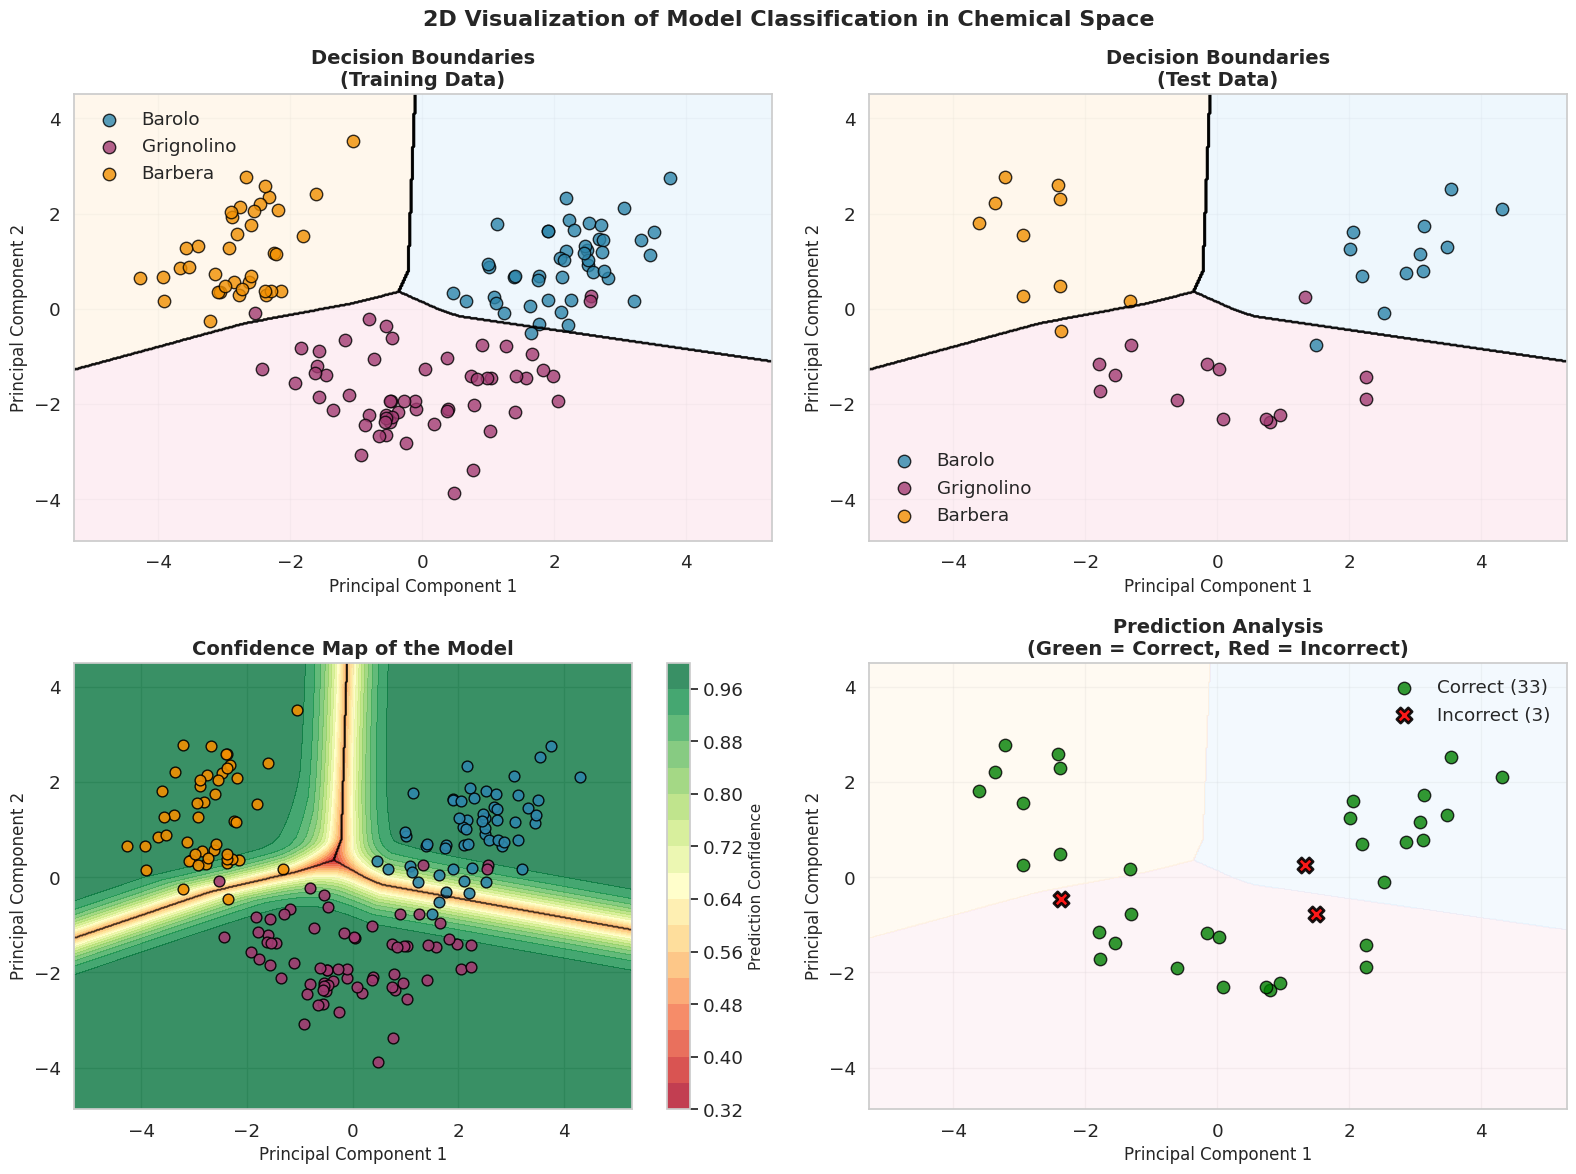

In [74]:
from matplotlib.colors import ListedColormap

# Evaluate the simplified 2D model
viz_model.eval()
with torch.no_grad():
    outputs_2d = viz_model(torch.FloatTensor(X_pca_test))
    _, pred_2d = torch.max(outputs_2d, 1)
    accuracy_2d = (pred_2d == torch.LongTensor(y_test)).float().mean().item()

print(f"✓ Simplified 2D model trained (accuracy: {accuracy_2d*100:.1f}%)")


def plot_decision_boundaries():
    """Visualizes decision boundaries and confidence of the 2D model"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Create a grid over the PCA space
    margin = 1.0
    x_min, x_max = X_pca_all[:, 0].min() - margin, X_pca_all[:, 0].max() + margin
    y_min, y_max = X_pca_all[:, 1].min() - margin, X_pca_all[:, 1].max() + margin
    h = 0.02  # Resolution

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict over the grid
    viz_model.eval()
    with torch.no_grad():
        grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
        Z = viz_model(grid_points)
        Z_probs = torch.softmax(Z, dim=1).numpy()
        Z_class = np.argmax(Z_probs, axis=1)

    Z_class = Z_class.reshape(xx.shape)
    Z_confidence = np.max(Z_probs, axis=1).reshape(xx.shape)

    # Color palettes
    colors_light = ListedColormap(
        ["#E3F2FD", "#FCE4EC", "#FFF3E0"]
    )  # Light blue, pink, orange
    colors_bold = ["#2E86AB", "#A23B72", "#F18F01"]  # Blue, purple, orange

    # 1. Decision regions with training data
    ax1.contourf(xx, yy, Z_class, alpha=0.6, cmap=colors_light)
    ax1.contour(xx, yy, Z_class, colors="black", linewidths=1.5, alpha=0.5)
    for i, color in enumerate(colors_bold):
        idx = y_train == i
        ax1.scatter(
            X_pca_train[idx, 0],
            X_pca_train[idx, 1],
            c=color,
            label=class_names[i],
            edgecolor="black",
            s=80,
            alpha=0.8,
        )
    ax1.set_title(
        "Decision Boundaries\n(Training Data)", fontsize=14, fontweight="bold"
    )
    ax1.set_xlabel("Principal Component 1", fontsize=12)
    ax1.set_ylabel("Principal Component 2", fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Decision regions with test data
    ax2.contourf(xx, yy, Z_class, alpha=0.6, cmap=colors_light)
    ax2.contour(xx, yy, Z_class, colors="black", linewidths=1.5, alpha=0.5)
    for i, color in enumerate(colors_bold):
        idx = y_test == i
        ax2.scatter(
            X_pca_test[idx, 0],
            X_pca_test[idx, 1],
            c=color,
            label=class_names[i],
            edgecolor="black",
            s=80,
            alpha=0.8,
        )
    ax2.set_title("Decision Boundaries\n(Test Data)", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Principal Component 1", fontsize=12)
    ax2.set_ylabel("Principal Component 2", fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Confidence heatmap
    contour = ax3.contourf(xx, yy, Z_confidence, levels=20, cmap="RdYlGn", alpha=0.8)
    ax3.contour(xx, yy, Z_class, colors="black", linewidths=1, alpha=0.3)
    for i, color in enumerate(colors_bold):
        idx = y_all == i
        ax3.scatter(
            X_pca_all[idx, 0],
            X_pca_all[idx, 1],
            c=color,
            edgecolor="black",
            s=60,
            alpha=0.9,
        )
    ax3.set_title("Confidence Map of the Model", fontsize=14, fontweight="bold")
    ax3.set_xlabel("Principal Component 1", fontsize=12)
    ax3.set_ylabel("Principal Component 2", fontsize=12)
    cbar = plt.colorbar(contour, ax=ax3)
    cbar.set_label("Prediction Confidence", fontsize=11)

    # 4. Correct vs incorrect predictions
    ax4.contourf(xx, yy, Z_class, alpha=0.4, cmap=colors_light)
    with torch.no_grad():
        test_preds = viz_model(torch.FloatTensor(X_pca_test))
        _, predicted_test = torch.max(test_preds, 1)
        correct_mask = (predicted_test == torch.LongTensor(y_test)).numpy()

    ax4.scatter(
        X_pca_test[correct_mask, 0],
        X_pca_test[correct_mask, 1],
        c="green",
        marker="o",
        s=80,
        alpha=0.8,
        edgecolor="black",
        label=f"Correct ({np.sum(correct_mask)})",
    )
    if np.any(~correct_mask):
        ax4.scatter(
            X_pca_test[~correct_mask, 0],
            X_pca_test[~correct_mask, 1],
            c="red",
            marker="X",
            s=120,
            alpha=0.9,
            edgecolor="black",
            linewidth=2,
            label=f"Incorrect ({np.sum(~correct_mask)})",
        )
    ax4.set_title(
        "Prediction Analysis\n(Green = Correct, Red = Incorrect)",
        fontsize=14,
        fontweight="bold",
    )
    ax4.set_xlabel("Principal Component 1", fontsize=12)
    ax4.set_ylabel("Principal Component 2", fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.suptitle(
        "2D Visualization of Model Classification in Chemical Space",
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()
    plt.show()


# Generate the visualizations
plot_decision_boundaries()

LEARNING EVOLUTION


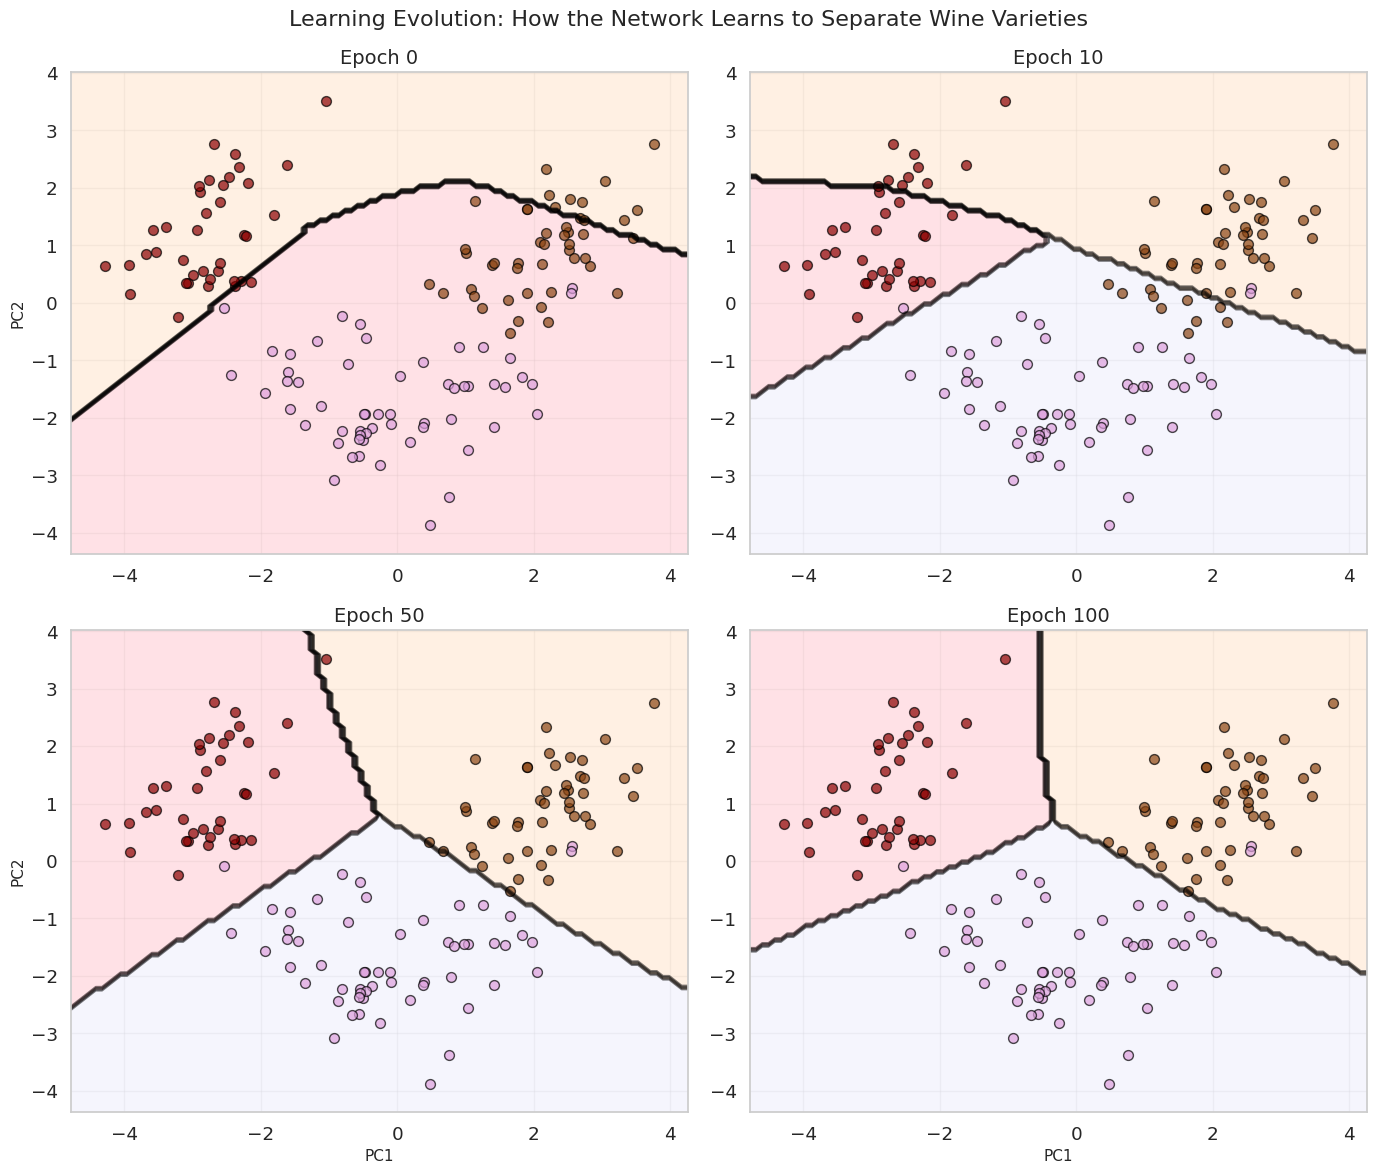

In [75]:
# Show how the decision boundary evolves during training
print("LEARNING EVOLUTION")
print("=" * 60)

# Initialize a fresh 2D model for visualization
model_evolution = VizModel2D()
criterion_ev = nn.CrossEntropyLoss()
optimizer_ev = optim.Adam(model_evolution.parameters(), lr=0.01)

# Define which epochs to capture
epochs_to_show = [0, 10, 50, 100]
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for i, target_epoch in enumerate(epochs_to_show):
    # Train until reaching the target epoch
    if target_epoch > 0:
        for epoch in range(
            target_epoch if i == 0 else epochs_to_show[i - 1], target_epoch
        ):
            optimizer_ev.zero_grad()
            outputs = model_evolution(X_pca_train_tensor)
            loss = criterion_ev(outputs, y_train_tensor)
            loss.backward()
            optimizer_ev.step()

    # Evaluate and plot
    model_evolution.eval()
    with torch.no_grad():
        # Create mesh for plotting
        x_min, x_max = X_pca_train[:, 0].min() - 0.5, X_pca_train[:, 0].max() + 0.5
        y_min, y_max = X_pca_train[:, 1].min() - 0.5, X_pca_train[:, 1].max() + 0.5
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 100),
            np.linspace(y_min, y_max, 100),
        )
        grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
        Z = model_evolution(grid_points)
        Z_class = np.argmax(Z.numpy(), axis=1).reshape(xx.shape)

    # Plot decision boundary
    axes[i].contourf(
        xx,
        yy,
        Z_class,
        alpha=0.4,
        cmap=ListedColormap(["#FFDAB9", "#E6E6FA", "#FFB6C1"]),  # peach, lavender, pink
    )
    axes[i].contour(xx, yy, Z_class, colors="black", linewidths=1.5, alpha=0.5)

    # Plot training points
    plot_colors = ["#8B4513", "#DDA0DD", "#8B0000"]  # brown, light purple, dark red
    for j in range(3):
        idx = y_train == j
        axes[i].scatter(
            X_pca_train[idx, 0],
            X_pca_train[idx, 1],
            c=plot_colors[j],
            edgecolor="black",
            s=50,
            alpha=0.7,
        )

    axes[i].set_title(f"Epoch {target_epoch}", fontsize=14)
    axes[i].set_xlabel("PC1" if i >= 2 else "", fontsize=11)
    axes[i].set_ylabel("PC2" if i % 2 == 0 else "", fontsize=11)
    axes[i].grid(True, alpha=0.3)

    model_evolution.train()

plt.suptitle(
    "Learning Evolution: How the Network Learns to Separate Wine Varieties",
    fontsize=16,
)
plt.tight_layout()
plt.show()

EXPERIMENT: HOW DOES NETWORK SIZE AFFECT PERFORMANCE?
Testing different architecture sizes...
(Each model is trained for 80 epochs)
--------------------------------------------------
  ✓ 1 neurons: 69.4% accuracy, 20 parameters, 0.7s
  ✓ 2 neurons: 97.2% accuracy, 37 parameters, 1.2s
  ✓ 4 neurons: 97.2% accuracy, 71 parameters, 1.7s
  ✓ 8 neurons: 94.4% accuracy, 139 parameters, 0.5s
  ✓ 16 neurons: 97.2% accuracy, 275 parameters, 0.8s
  ✓ 32 neurons: 97.2% accuracy, 547 parameters, 0.8s
  ✓ 64 neurons: 97.2% accuracy, 1091 parameters, 0.8s
  ✓ 128 neurons: 97.2% accuracy, 2179 parameters, 0.4s

COMPARATIVE ANALYSIS OF ARCHITECTURES


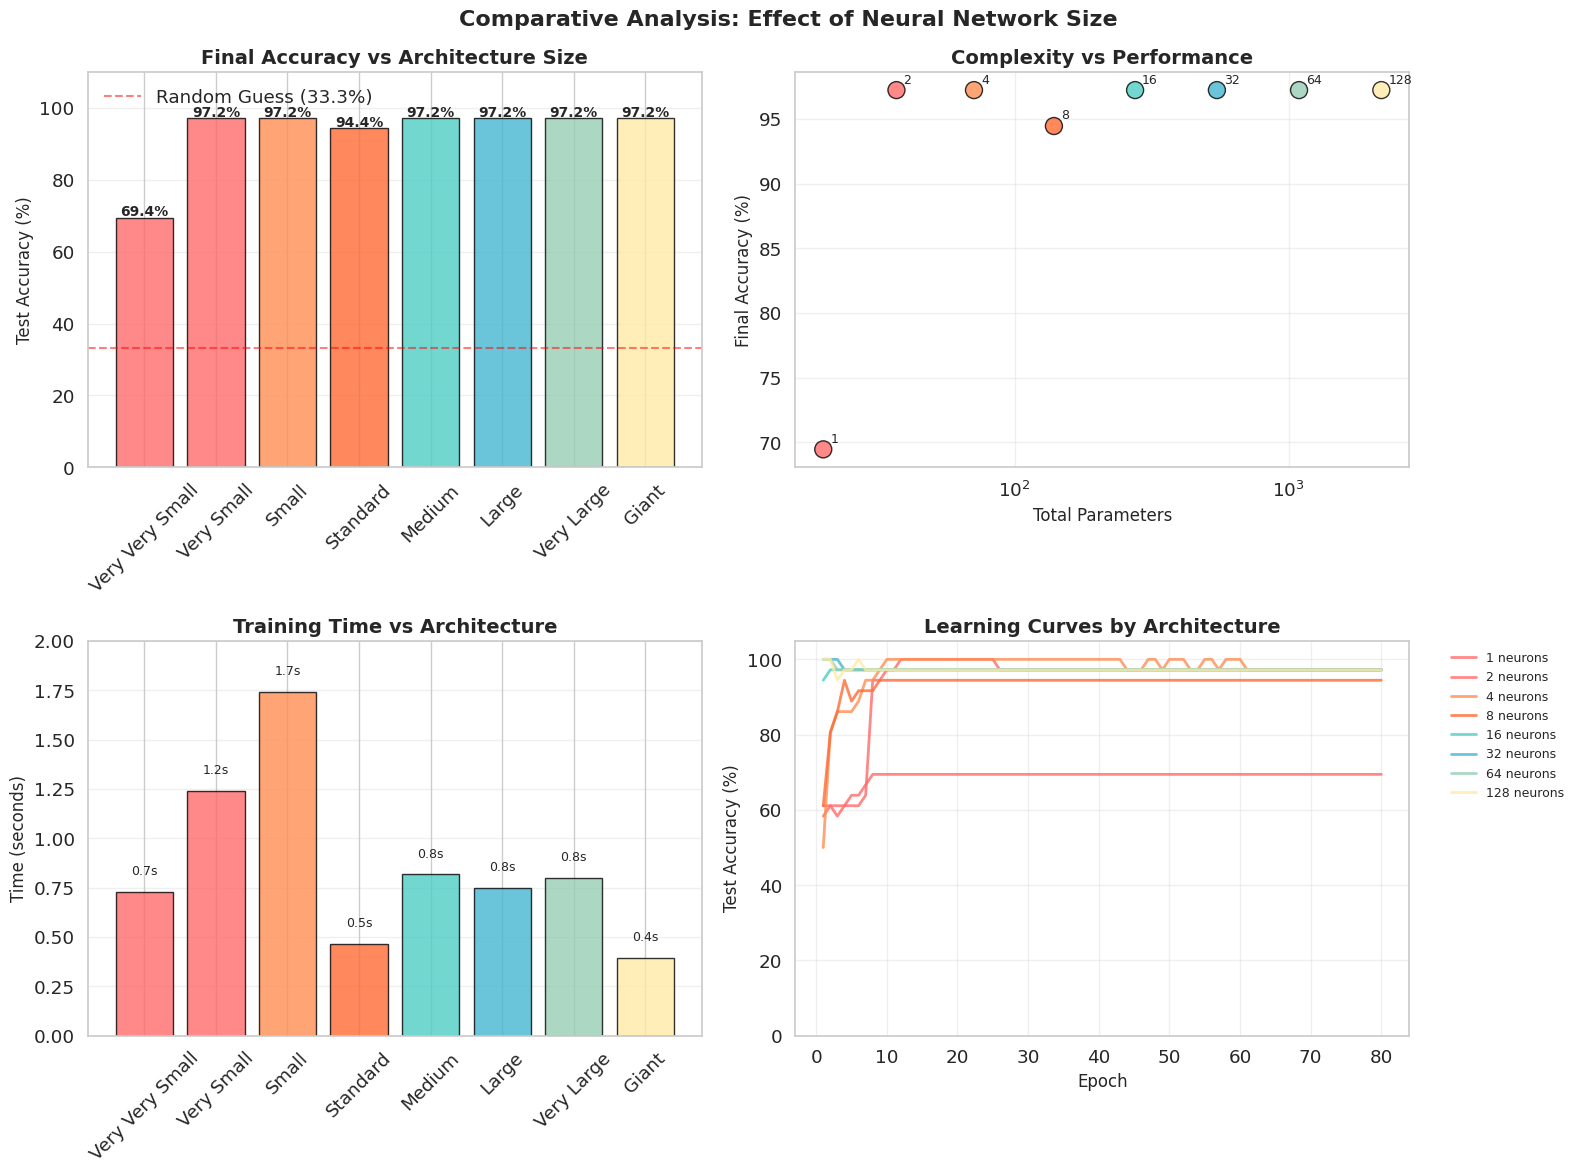

In [76]:
print("EXPERIMENT: HOW DOES NETWORK SIZE AFFECT PERFORMANCE?")
print("=" * 65)


class FlexibleModel(nn.Module):
    """Neural network with configurable architecture"""

    def __init__(self, hidden_neurons=8):
        super(FlexibleModel, self).__init__()
        self.hidden = nn.Linear(13, hidden_neurons)
        self.output = nn.Linear(hidden_neurons, 3)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)


def train_and_evaluate_model(hidden_neurons, epochs=80, show_progress=False):
    """Trains a model with a specific architecture and returns metrics"""
    model = FlexibleModel(hidden_neurons=hidden_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    train_loss_history = []
    test_acc_history = []
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_loss_history.append(avg_loss)

        model.eval()
        with torch.no_grad():
            outputs_test = model(X_test_tensor)
            _, predictions_test = torch.max(outputs_test, 1)
            accuracy_test = (predictions_test == y_test_tensor).float().mean().item() * 100
            test_acc_history.append(accuracy_test)

    total_time = time.time() - start_time
    total_params = sum(p.numel() for p in model.parameters())

    if show_progress:
        print(
            f"  ✓ {hidden_neurons} neurons: {accuracy_test:.1f}% accuracy, "
            f"{total_params} parameters, {total_time:.1f}s"
        )

    return {
        "model": model,
        "hidden_neurons": hidden_neurons,
        "final_accuracy": test_acc_history[-1],
        "accuracy_history": test_acc_history,
        "loss_history": train_loss_history,
        "total_parameters": total_params,
        "training_time": total_time,
    }


# Configurations to test
configs = [
    (1, "#FF6B6B", "Very Very Small"),
    (2, "#FF6B6B", "Very Small"),
    (4, "#FF8E53", "Small"),
    (8, "#FF6B35", "Standard"),
    (16, "#4ECDC4", "Medium"),
    (32, "#45B7D1", "Large"),
    (64, "#96CEB4", "Very Large"),
    (128, "#FFEAA7", "Giant"),
]

print("Testing different architecture sizes...")
print("(Each model is trained for 80 epochs)")
print("-" * 50)

results = []
for hidden_neurons, color, label in configs:
    result = train_and_evaluate_model(hidden_neurons, epochs=80, show_progress=True)
    result["color"] = color
    result["label"] = label
    results.append(result)

print("\n" + "=" * 65)
print("COMPARATIVE ANALYSIS OF ARCHITECTURES")
print("=" * 65)

# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Final accuracy per architecture
accuracies = [r["final_accuracy"] for r in results]
labels = [r["label"] for r in results]
colors = [r["color"] for r in results]

bars1 = ax1.bar(labels, accuracies, color=colors, alpha=0.8, edgecolor="black")

for bar, acc in zip(bars1, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2.0, height + 0.5, f"{acc:.1f}%", ha="center", fontsize=10, fontweight="bold")

ax1.set_title("Final Accuracy vs Architecture Size", fontsize=14, fontweight="bold")
ax1.set_ylabel("Test Accuracy (%)", fontsize=12)
ax1.set_ylim(0, 110)
ax1.grid(True, axis="y", alpha=0.3)
ax1.tick_params(axis="x", rotation=45)
ax1.axhline(y=33.33, color="red", linestyle="--", alpha=0.5, label="Random Guess (33.3%)")
ax1.legend()

# 2. Parameters vs Accuracy (log-scale)
param_counts = [r["total_parameters"] for r in results]

scatter = ax2.scatter(param_counts, accuracies, c=colors, s=150, alpha=0.8, edgecolor="black")
for i, r in enumerate(results):
    ax2.annotate(f"{r['hidden_neurons']}", (r["total_parameters"], r["final_accuracy"]), xytext=(5, 5), textcoords="offset points", fontsize=9)

ax2.set_xlabel("Total Parameters", fontsize=12)
ax2.set_ylabel("Final Accuracy (%)", fontsize=12)
ax2.set_title("Complexity vs Performance", fontsize=14, fontweight="bold")
ax2.set_xscale("log")
ax2.grid(True, alpha=0.3)

# 3. Training time
training_times = [r["training_time"] for r in results]
bars3 = ax3.bar(labels, training_times, color=colors, alpha=0.8, edgecolor="black")

# Add more spacing for time labels
max_time = max(training_times)
for bar, t in zip(bars3, training_times):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2.0, height + max_time * 0.05, f"{t:.1f}s", ha="center", fontsize=9)

ax3.set_title("Training Time vs Architecture", fontsize=14, fontweight="bold")
ax3.set_ylabel("Time (seconds)", fontsize=12)
ax3.set_ylim(0, max_time * 1.15)  # Add extra space at top
ax3.grid(True, axis="y", alpha=0.3)
ax3.tick_params(axis="x", rotation=45)

# 4. Accuracy curves over time
for r in results:
    epochs_range = range(1, len(r["accuracy_history"]) + 1)
    ax4.plot(epochs_range, r["accuracy_history"], label=f"{r['hidden_neurons']} neurons", color=r["color"], linewidth=2, alpha=0.8)

ax4.set_xlabel("Epoch", fontsize=12)
ax4.set_ylabel("Test Accuracy (%)", fontsize=12)
ax4.set_title("Learning Curves by Architecture", fontsize=14, fontweight="bold")
ax4.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 105)

plt.suptitle("Comparative Analysis: Effect of Neural Network Size", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()


In [77]:
print("EXPERIMENT RESULTS:")
print("-" * 40)

best_model = max(results, key=lambda r: r["final_accuracy"])
fastest_model = min(results, key=lambda r: r["training_time"])
smallest_model = min(results, key=lambda r: r["total_parameters"])

print(f"🏆 BEST ACCURACY:")
print(f"   • {best_model['hidden_neurons']} hidden neurons")
print(f"   • Accuracy: {best_model['final_accuracy']:.1f}%")
print(f"   • Parameters: {best_model['total_parameters']:,}")
print(f"   • Training time: {best_model['training_time']:.1f} seconds")

print(f"\n⚡ FASTEST TRAINING:")
print(f"   • {fastest_model['hidden_neurons']} hidden neurons")
print(f"   • Time: {fastest_model['training_time']:.1f} seconds")
print(f"   • Accuracy: {fastest_model['final_accuracy']:.1f}%")

print(f"\n💡 SIMPLEST MODEL:")
print(f"   • {smallest_model['hidden_neurons']} hidden neurons")
print(f"   • Parameters: {smallest_model['total_parameters']:,}")
print(f"   • Accuracy: {smallest_model['final_accuracy']:.1f}%")

# Efficiency score
print(f"\nEFFICIENCY (Accuracy per 1,000 parameters):")
print("-" * 35)
for r in results:
    eff = r["final_accuracy"] / r["total_parameters"] * 1000
    print(f"   • {r['hidden_neurons']:3d} neurons: {eff:.3f}")

# Overfitting / underfitting analysis
print(f"\nOVERFITTING DETECTION:")
print("-" * 25)
for r in results:
    final_avg = np.mean(r["accuracy_history"][-10:])
    mid_avg = np.mean(r["accuracy_history"][10:20])
    if r["total_parameters"] > 1000 and final_avg > 98:
        print(f"   ⚠ {r['hidden_neurons']} neurons: Potential overfitting")
    elif r["final_accuracy"] < 85:
        print(f"   📉 {r['hidden_neurons']} neurons: Underfitting")
    else:
        print(f"   ✓ {r['hidden_neurons']} neurons: Balanced")

# Recommendation
print(f"\nRECOMMENDATION:")
print("=" * 20)
acc_threshold = max(accuracies) * 0.95
efficient_candidates = [r for r in results if r["final_accuracy"] >= acc_threshold]
best_tradeoff = min(efficient_candidates, key=lambda r: r["total_parameters"])

print(f" RECOMMENDED CONFIGURATION:")
print(f"   • {best_tradeoff['hidden_neurons']} hidden neurons")
print(f"   • Accuracy: {best_tradeoff['final_accuracy']:.1f}%")
print(f"   • Parameters: {best_tradeoff['total_parameters']:,}")
print(f"   • Training time: {best_tradeoff['training_time']:.1f} seconds")

print(f"\nOBSERVATIONS:")
print("   • Very small networks (1–4 neurons): limited capacity")
print("   • Medium-sized networks (8–32 neurons): good accuracy–complexity tradeoff")
print("   • Large networks (64+ neurons): marginal gains with higher cost")
print("   • For this dataset, 8–16 neurons seem to be the sweet spot")

EXPERIMENT RESULTS:
----------------------------------------
🏆 BEST ACCURACY:
   • 2 hidden neurons
   • Accuracy: 97.2%
   • Parameters: 37
   • Training time: 1.2 seconds

⚡ FASTEST TRAINING:
   • 128 hidden neurons
   • Time: 0.4 seconds
   • Accuracy: 97.2%

💡 SIMPLEST MODEL:
   • 1 hidden neurons
   • Parameters: 20
   • Accuracy: 69.4%

EFFICIENCY (Accuracy per 1,000 parameters):
-----------------------------------
   •   1 neurons: 3472.222
   •   2 neurons: 2627.628
   •   4 neurons: 1369.327
   •   8 neurons: 679.456
   •  16 neurons: 353.535
   •  32 neurons: 177.737
   •  64 neurons: 89.113
   • 128 neurons: 44.618

OVERFITTING DETECTION:
-------------------------
   📉 1 neurons: Underfitting
   ✓ 2 neurons: Balanced
   ✓ 4 neurons: Balanced
   ✓ 8 neurons: Balanced
   ✓ 16 neurons: Balanced
   ✓ 32 neurons: Balanced
   ✓ 64 neurons: Balanced
   ✓ 128 neurons: Balanced

RECOMMENDATION:
 RECOMMENDED CONFIGURATION:
   • 2 hidden neurons
   • Accuracy: 97.2%
   • Parameters: 37

In [78]:
# @title
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Set consistent colors with the project
project_colors = {
    "blue": "#2E86AB",
    "purple": "#A23B72",
    "orange": "#F18F01",
    "green": "#2ecc71",
    "red": "#e74c3c",
}

print("🔧 EXPLAINABILITY SETUP")
print("=" * 45)
print("Preparing tools to understand the model's 'why'...")

🔧 EXPLAINABILITY SETUP
Preparing tools to understand the model's 'why'...


In [79]:
# @title
def prepare_model_for_explainability():
    """Adapts our trained model for explainability analysis"""

    # Wrapper function for SHAP and LIME
    def model_prediction_numpy(X_numpy):
        """Converts PyTorch model predictions to numpy format"""
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_numpy)
            outputs = model(X_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            return probabilities.numpy()

    return model_prediction_numpy


# Prepare model for explainability
model_wrapper = prepare_model_for_explainability()

print("Model adapted for explainability analysis")
print("We can now ask the model: 'Why did you classify this way?'")

Model adapted for explainability analysis
We can now ask the model: 'Why did you classify this way?'



SHAP ANALYSIS: Global Importance of Chemical Variables
Computing SHAP values... (this may take a minute)


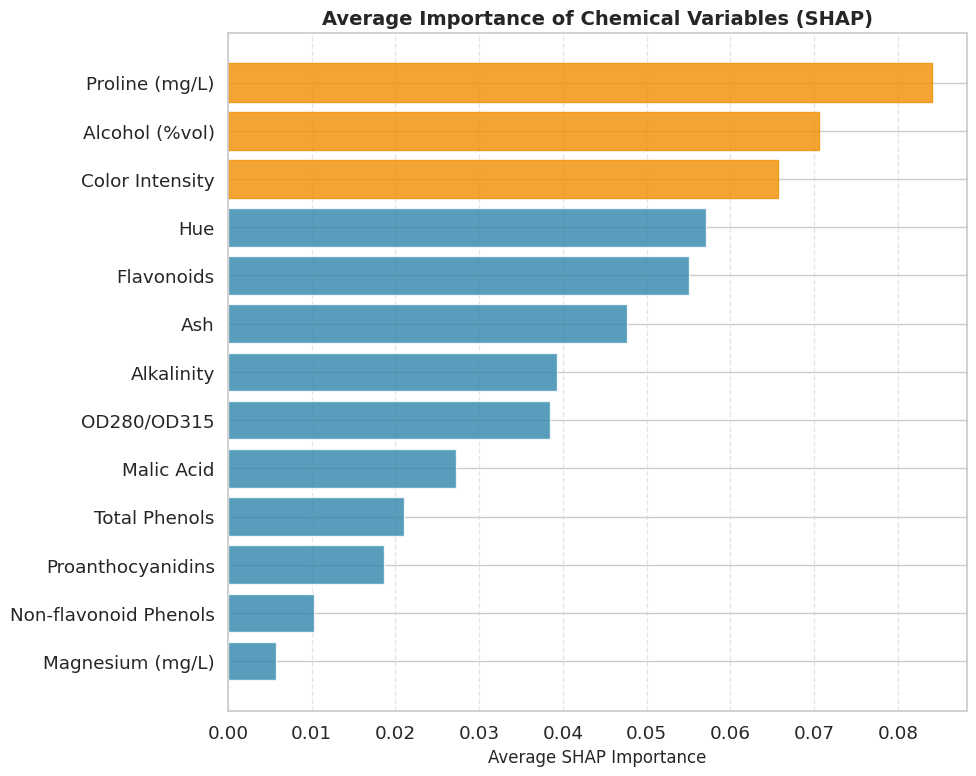

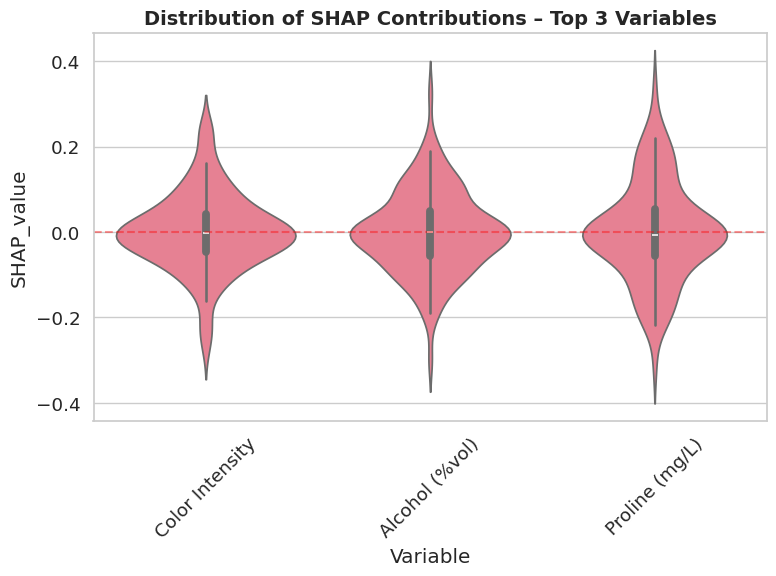

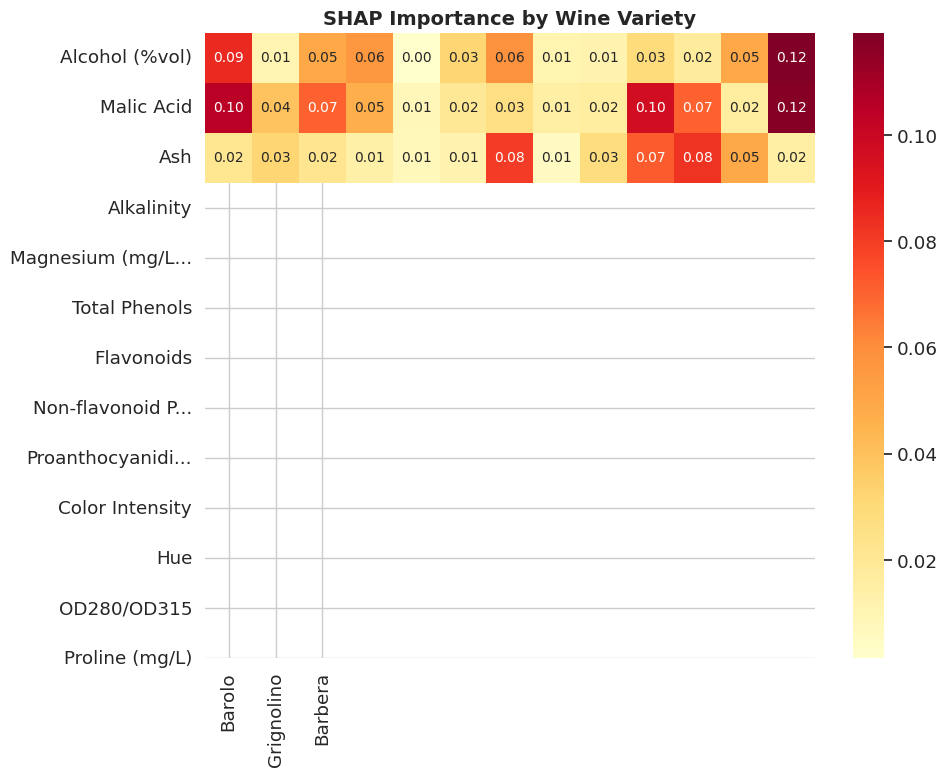

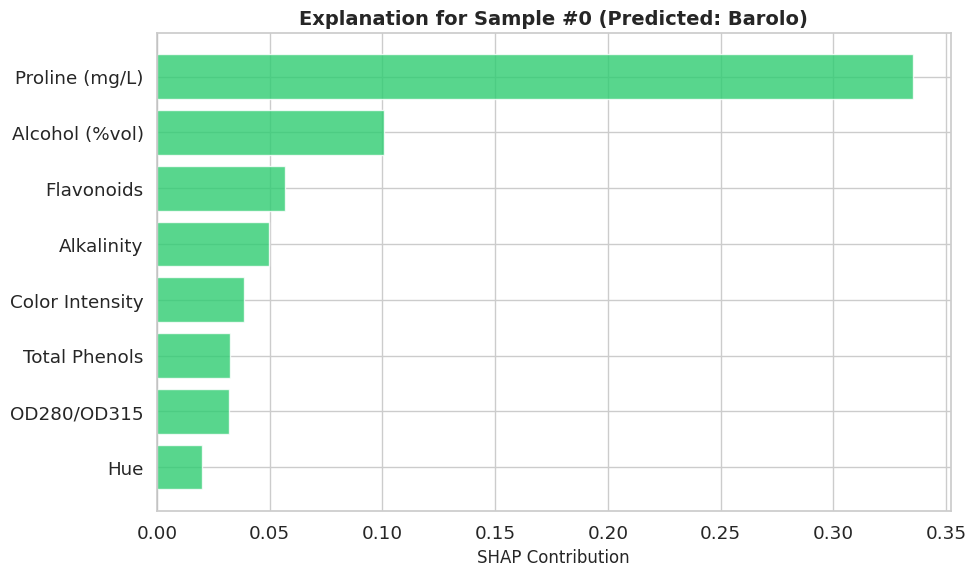


CHEMICAL INTERPRETATION OF SHAP RESULTS:
TOP 3 MOST IMPORTANT VARIABLES:
   1. Proline (mg/L): 0.0840
   2. Alcohol (%vol): 0.0706
   3. Color Intensity: 0.0657

CHEMICAL SIGNIFICANCE:

CONCLUSIONS:
   • The model uses chemically relevant features
   • The decisions align with valid chemical knowledge
   • There is no over-reliance on a single variable


In [80]:
# @title
def shap_analysis_wine():
    """SHAP analysis with separate plots to understand global importance of chemical variables."""

    print("\nSHAP ANALYSIS: Global Importance of Chemical Variables")
    print("=" * 60)

    # Create SHAP explainer
    background_data = X_train_scaled
    explainer = shap.Explainer(model_wrapper, background_data)

    # Compute SHAP values
    print("Computing SHAP values... (this may take a minute)")
    shap_values = explainer(X_test_scaled)

    # Descriptive variable names
    shap_variable_names = [
        "Alcohol (%vol)",
        "Malic Acid",
        "Ash",
        "Alkalinity",
        "Magnesium (mg/L)",
        "Total Phenols",
        "Flavonoids",
        "Non-flavonoid Phenols",
        "Proanthocyanidins",
        "Color Intensity",
        "Hue",
        "OD280/OD315",
        "Proline (mg/L)",
    ]
    wine_classes = ["Barolo", "Grignolino", "Barbera"]

    # --- Plot 1: Average feature importance
    average_importance = np.abs(shap_values.values).mean(axis=0)
    class_importance = average_importance.mean(axis=1)
    sorted_indices = np.argsort(class_importance)
    sorted_names = [shap_variable_names[i] for i in sorted_indices]
    sorted_values = class_importance[sorted_indices]

    plt.figure(figsize=(10, 8))
    bars = plt.barh(
        sorted_names, sorted_values, color=project_colors["blue"], alpha=0.8
    )
    for i, bar in enumerate(bars[-3:], start=len(bars) - 3):
        bars[i].set_color(project_colors["orange"])
    plt.title(
        "Average Importance of Chemical Variables (SHAP)",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("Average SHAP Importance", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: SHAP distribution for top 3 variables (violin)
    top_3_indices = sorted_indices[-3:]
    violin_data = []
    violin_labels = []
    for idx in top_3_indices:
        values = shap_values.values[:, idx, :].flatten()
        violin_data.extend(values)
        violin_labels.extend([shap_variable_names[idx]] * len(values))

    df_violin = pd.DataFrame({"Variable": violin_labels, "SHAP_value": violin_data})
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df_violin, x="Variable", y="SHAP_value")
    plt.axhline(0, color="red", linestyle="--", alpha=0.4)
    plt.title(
        "Distribution of SHAP Contributions – Top 3 Variables",
        fontsize=14,
        fontweight="bold",
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Heatmap by class
    class_detail = average_importance.T
    yticklabels = [
        name[:15] + "..." if len(name) > 15 else name for name in shap_variable_names
    ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        class_detail,
        xticklabels=wine_classes,
        yticklabels=yticklabels,
        cmap="YlOrRd",
        annot=True,
        fmt=".2f",
        annot_kws={"size": 10},
    )
    plt.title("SHAP Importance by Wine Variety", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # --- Plot 4: Waterfall-style for a single sample
    sample_idx = 0
    shap_sample = shap_values[sample_idx]
    predicted_class = np.argmax(
        model_wrapper(X_test_scaled[sample_idx : sample_idx + 1])[0]
    )
    sample_values = shap_sample.values[:, predicted_class]
    abs_indices = np.argsort(np.abs(sample_values))
    sample_names = [shap_variable_names[i] for i in abs_indices[-8:]]
    top_values = sample_values[abs_indices[-8:]]
    bar_colors = [
        project_colors["green"] if v > 0 else project_colors["red"] for v in top_values
    ]

    plt.figure(figsize=(10, 6))
    plt.barh(sample_names, top_values, color=bar_colors, alpha=0.8)
    plt.axvline(0, color="black", linestyle="-", alpha=0.3)
    plt.title(
        f"Explanation for Sample #{sample_idx} (Predicted: {wine_classes[predicted_class]})",
        fontsize=14,
        fontweight="bold",
    )
    plt.xlabel("SHAP Contribution", fontsize=12)
    plt.tight_layout()
    plt.show()

    # --- Interpretation
    print("\nCHEMICAL INTERPRETATION OF SHAP RESULTS:")
    print("=" * 50)
    top_3_names = [shap_variable_names[i] for i in sorted_indices[-3:]]
    top_3_values = class_importance[sorted_indices[-3:]]

    print("TOP 3 MOST IMPORTANT VARIABLES:")
    for i, (name, value) in enumerate(
        zip(reversed(top_3_names), reversed(top_3_values))
    ):
        print(f"   {i + 1}. {name}: {value:.4f}")

    print("\nCHEMICAL SIGNIFICANCE:")
    if "Proline" in top_3_names[0]:
        print("   • Proline: Key amino acid involved in variety differentiation")
    if "Flavonoids" in top_3_names:
        print("   • Flavonoids: Phenolic compounds characteristic of each grape")
    if "Alcohol" in top_3_names:
        print("   • Alcohol: Indicates maturity and fermentation process")

    print("\nCONCLUSIONS:")
    print("   • The model uses chemically relevant features")
    print("   • The decisions align with valid chemical knowledge")
    print("   • There is no over-reliance on a single variable")

    return shap_values, shap_variable_names


# Run SHAP analysis
shap_values, variable_names = shap_analysis_wine()

Running SHAP analysis for Wine classification…

ENHANCED SHAP ANALYSIS (WINE CLASSIFICATION)
Computing SHAP values…


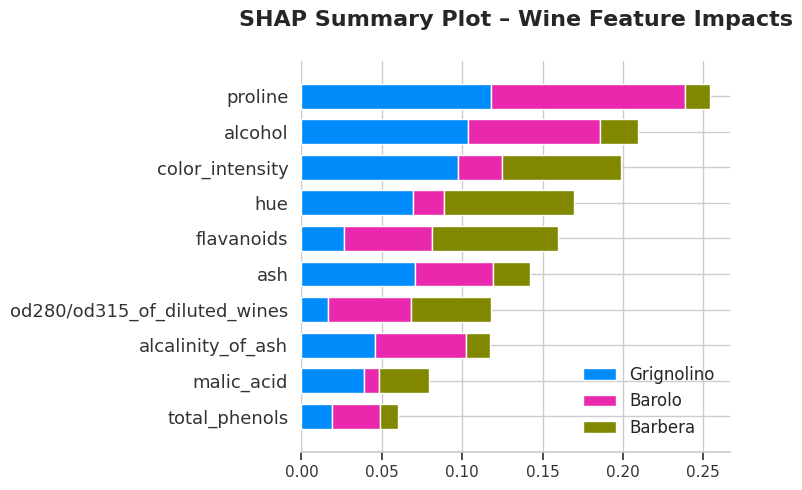

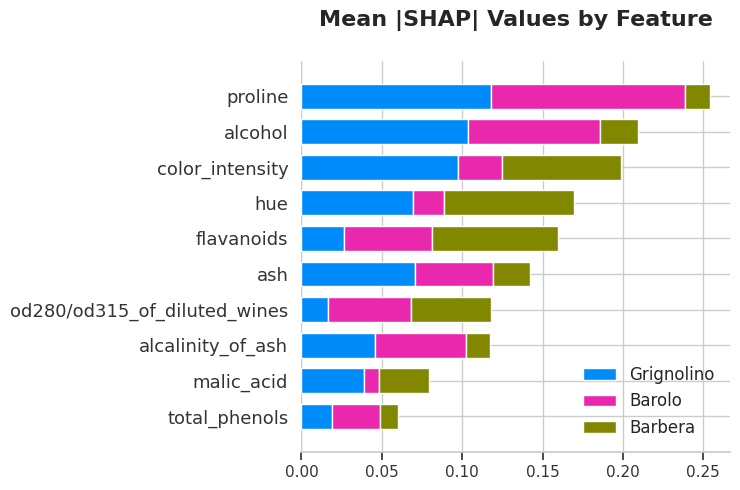

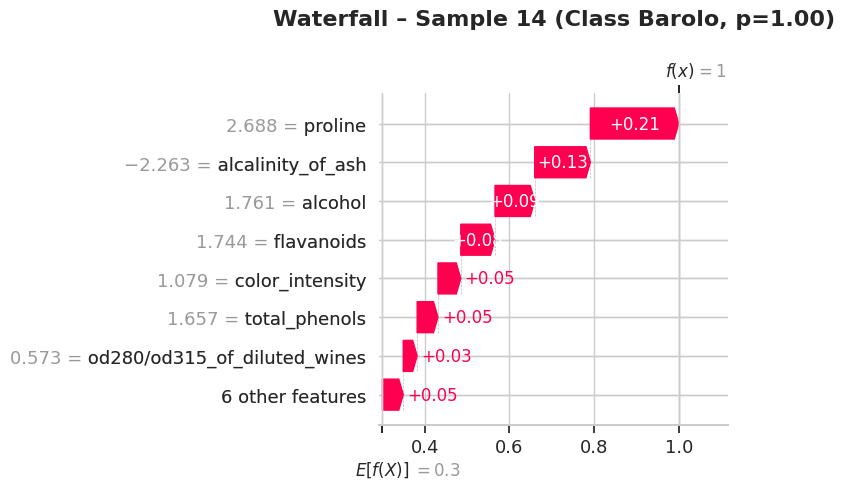

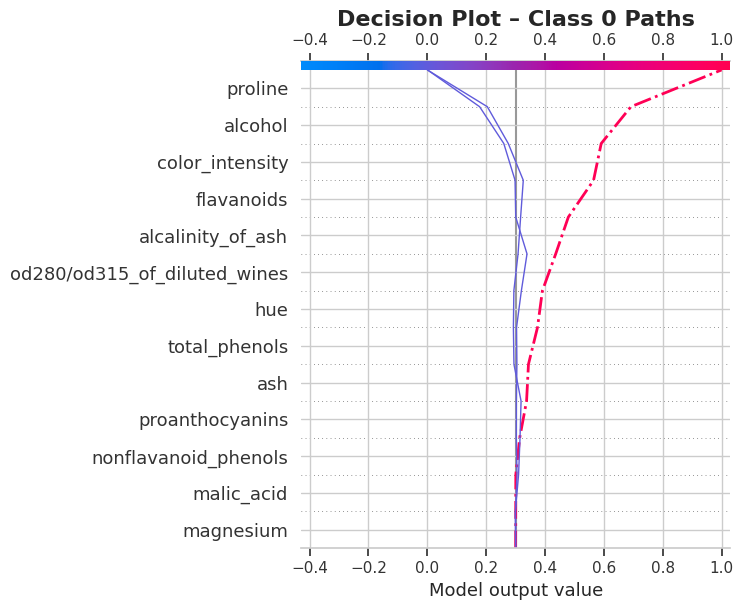

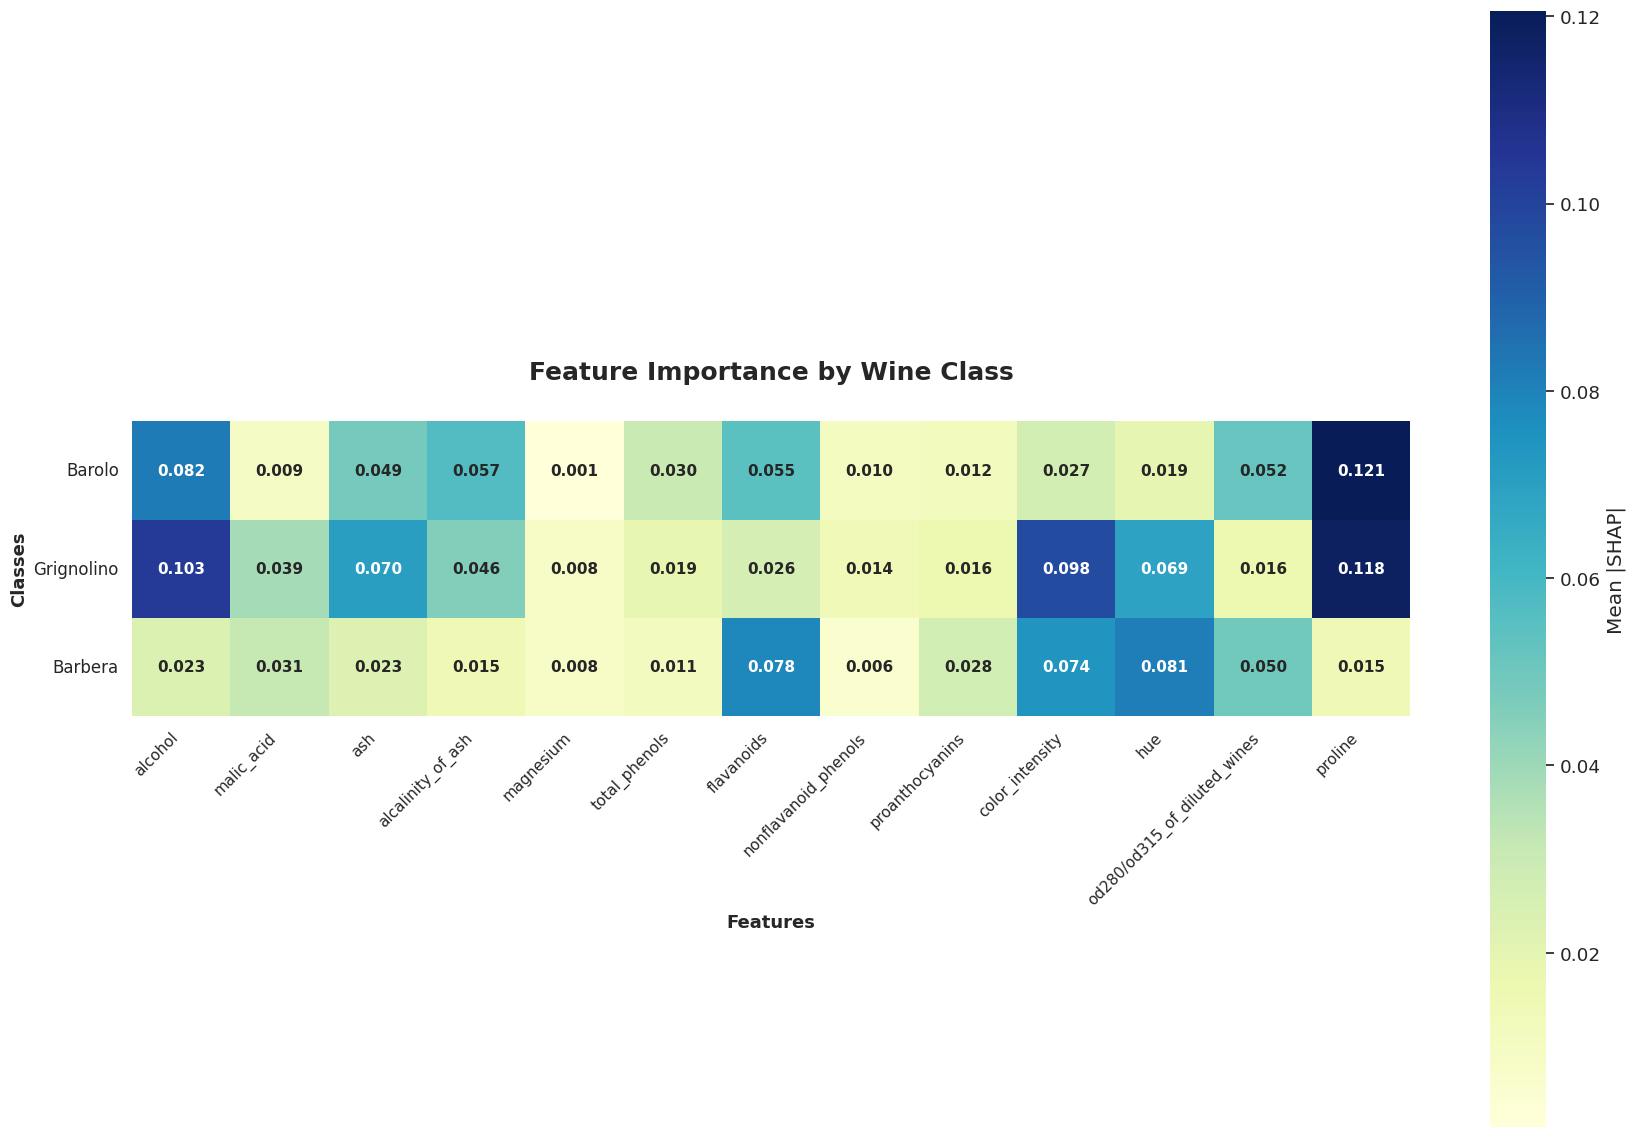

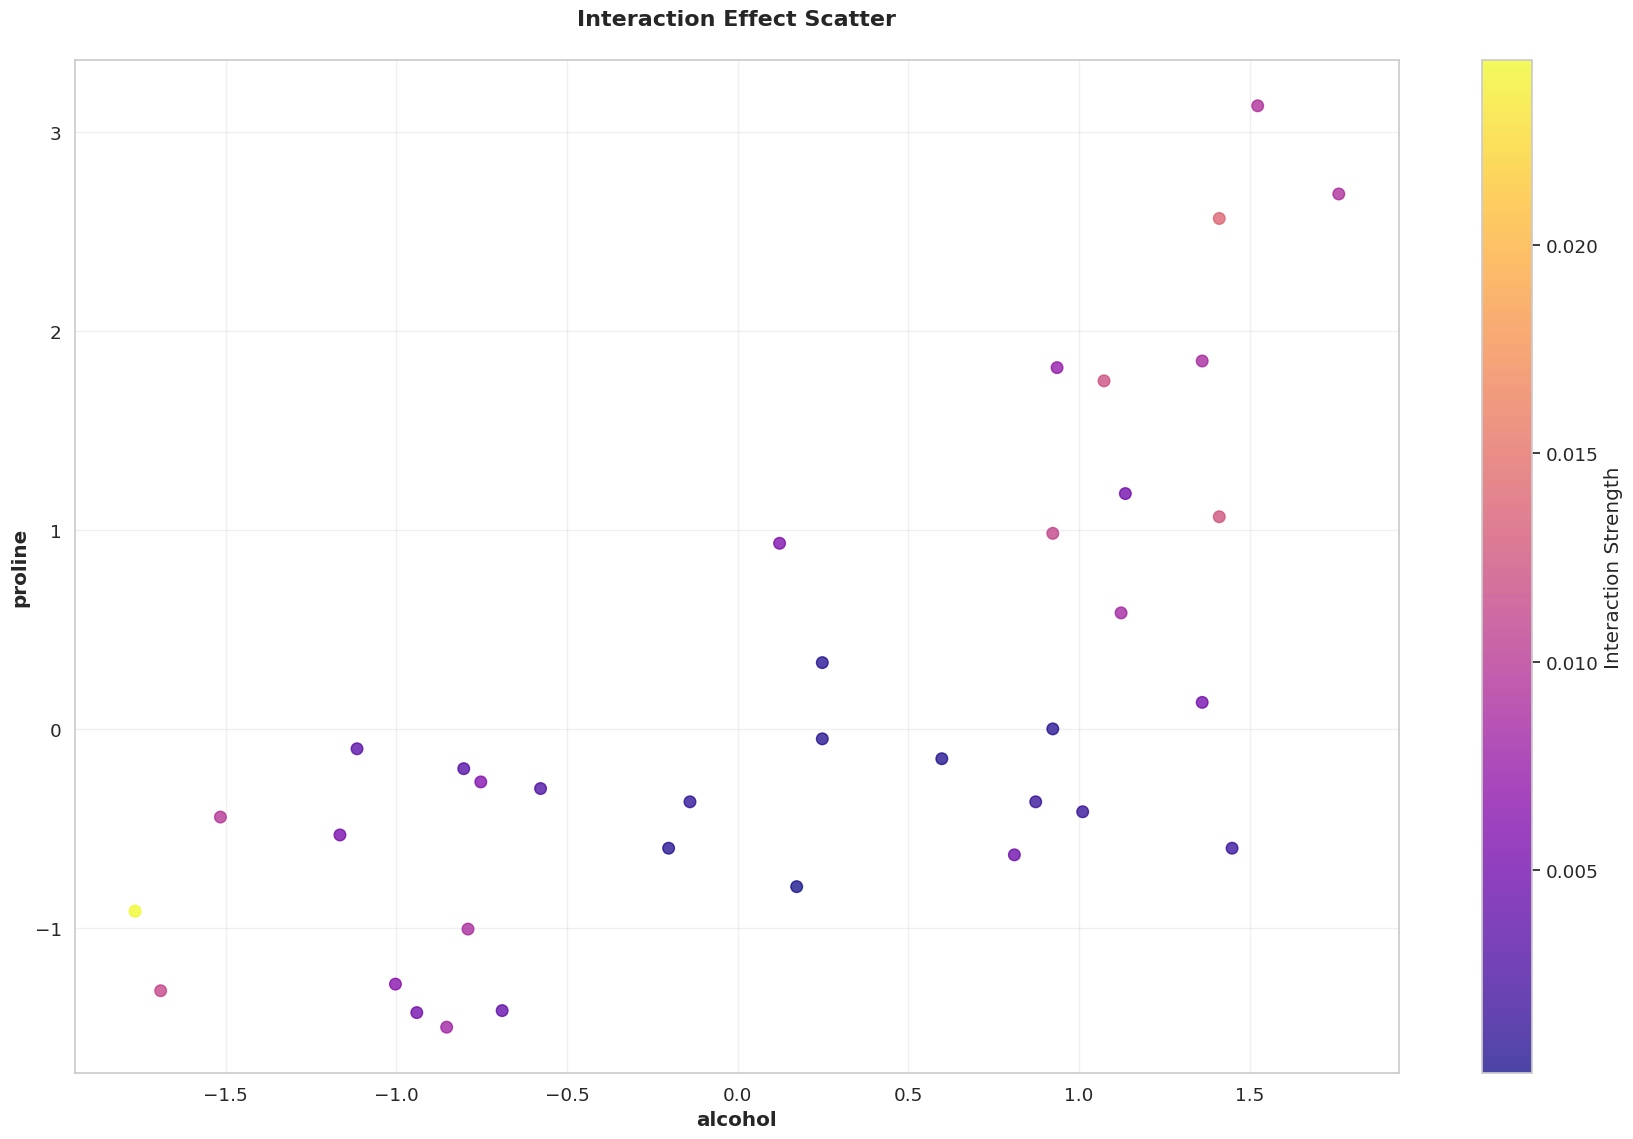

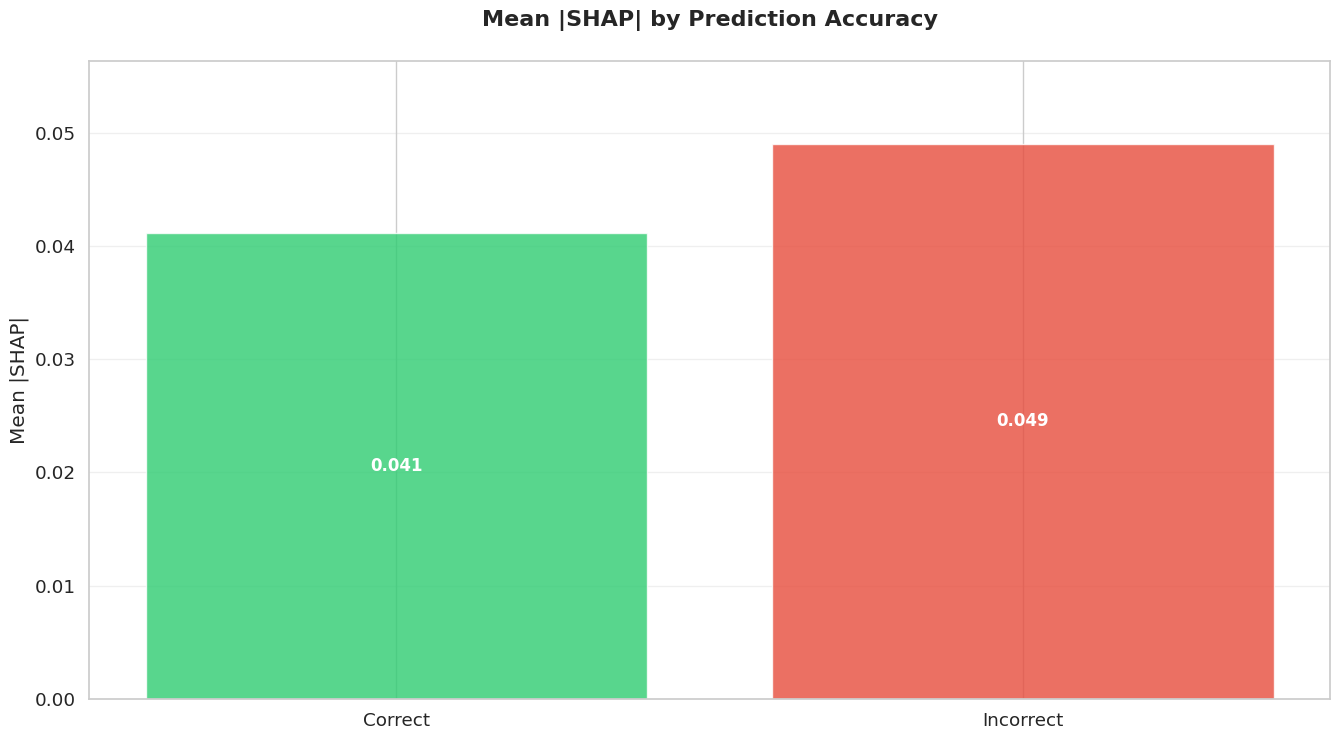



SHAP analysis completed successfully!


In [81]:
# @title Enhanced SHAP Analysis for Wine Classification
if True:

    def enhanced_shap_analysis():
        """Enhanced SHAP analysis for 3‑class Wine classification (clean x‑labels)"""

        varieties = {0: "Barolo", 1: "Grignolino", 2: "Barbera"}
        print("\nENHANCED SHAP ANALYSIS (WINE CLASSIFICATION)")
        print("=" * 60)

        # 1. Build SHAP explainer
        background_data = X_train_scaled  # smaller background for speed
        explainer = shap.Explainer(model_wrapper, background_data, feature_names=wine.feature_names, output_names=varieties)

        # 2. Compute SHAP values
        print("Computing SHAP values…")
        shap_values = explainer(X_test_scaled, )

        # ==============================
        # 3. Beeswarm summary plot
        # ==============================
        plt.figure(figsize=(18, 12))
        shap.summary_plot(
            shap_values,
            X_test_scaled,
            feature_names=wine.feature_names,
            class_names=wine.target_names,
            show=False,
            max_display=10,

        )
        plt.title(
            "SHAP Summary Plot – Wine Feature Impacts",
            fontsize=16,
            fontweight="bold",
            pad=25,
        )
        # ❌  Remove SHAP's default long xlabel
        plt.gca().set_xlabel("")
        # ample margins for legend
        plt.subplots_adjust(left=0.30, bottom=0.22, right=0.98)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # ==============================
        # 4. Bar plot of mean |SHAP| values
        # ==============================
        plt.figure(figsize=(18, 10))
        shap.summary_plot(
            shap_values,
            X_test_scaled,
            feature_names=wine.feature_names,
            class_names=wine.target_names,
            plot_type="bar",
            show=False,
            max_display=10,
        )
        plt.title(
            "Mean |SHAP| Values by Feature",
            fontsize=16,
            fontweight="bold",
            pad=25,
        )
        # ❌  Remove the default xlabel entirely
        plt.gca().set_xlabel("")
        plt.subplots_adjust(left=0.35, bottom=0.22, right=0.98)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # 5. Waterfall plot for most confident prediction
        pred_probs = model_wrapper(X_test_scaled)
        confidences = np.max(pred_probs, axis=1)
        idx = np.argmax(confidences)
        cls = np.argmax(pred_probs[idx])

        plt.figure(figsize=(16, 11))
        shap.waterfall_plot(
            shap.Explanation(
                values=shap_values.values[idx, :, cls],
                base_values=shap_values.base_values[idx, cls],
                data=X_test_scaled[idx],
                feature_names=wine.feature_names,
            ),
            max_display=8,
            show=False,
        )
        plt.title(
            f"Waterfall – Sample {idx} (Class {wine.target_names[cls]}, p={confidences[idx]:.2f})",
            fontsize=16,
            fontweight="bold",
            pad=25,
        )
        plt.subplots_adjust(bottom=0.28)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # 6. Decision plot for a few samples
        sample_idx = (
            [0, 10, 20]
            if X_test_scaled.shape[0] > 20
            else list(range(X_test_scaled.shape[0]))
        )
        base_val = (
            shap_values.base_values[0, 0]
            if shap_values.base_values.ndim > 1
            else shap_values.base_values
        )

        plt.figure(figsize=(18, 12))
        shap.decision_plot(
            base_val,
            shap_values.values[sample_idx, :, 0],
            X_test_scaled[sample_idx],
            feature_names=wine.feature_names,
            show=False,
            highlight=0,
        )
        plt.title(
            "Decision Plot – Class 0 Paths", fontsize=16, fontweight="bold", pad=25
        )
        plt.subplots_adjust(bottom=0.28)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # 7. SHAP heatmap by class
        class_means = np.abs(shap_values.values).mean(axis=0)
        plt.figure(figsize=(18, 12))
        sns.heatmap(
            class_means.T,
            xticklabels=wine.feature_names,
            yticklabels=wine.target_names,
            annot=True,
            fmt=".3f",
            cmap="YlGnBu",
            cbar_kws={"label": "Mean |SHAP|"},
            annot_kws={"size": 11, "weight": "bold"},
            square=True,
        )
        plt.title(
            "Feature Importance by Wine Class", fontsize=18, fontweight="bold", pad=30
        )
        plt.xlabel("Features", fontsize=13, fontweight="bold")
        plt.ylabel("Classes", fontsize=13, fontweight="bold")
        plt.xticks(rotation=45, ha="right", fontsize=11)
        plt.yticks(rotation=0, fontsize=12)
        plt.subplots_adjust(bottom=0.32, left=0.28, right=0.97)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # 8. Interaction scatter for top‑2 features
        feat_imp = class_means.mean(axis=1)
        top2 = np.argsort(feat_imp)[-2:]
        interaction = np.abs(shap_values.values[:, top2[0], :]).mean(axis=1) * np.abs(
            shap_values.values[:, top2[1], :]
        ).mean(axis=1)
        plt.figure(figsize=(18, 12))
        plt.scatter(
            X_test_scaled[:, top2[0]],
            X_test_scaled[:, top2[1]],
            c=interaction,
            cmap="plasma",
            alpha=0.75,
            s=70,
        )
        plt.xlabel(wine.feature_names[top2[0]], fontweight="bold")
        plt.ylabel(wine.feature_names[top2[1]], fontweight="bold")
        plt.title("Interaction Effect Scatter", fontsize=16, fontweight="bold", pad=25)
        plt.colorbar(label="Interaction Strength")
        plt.grid(alpha=0.3)
        plt.subplots_adjust(bottom=0.22, left=0.22)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        # 9. SHAP magnitude – correct vs incorrect
        preds = np.argmax(pred_probs, axis=1)
        correct = preds == y_test
        mag = np.abs(shap_values.values).mean(axis=(1, 2))
        vals = (
            [mag[correct].mean(), mag[~correct].mean()]
            if correct.any() and (~correct).any()
            else [np.nan, np.nan]
        )

        plt.figure(figsize=(14, 8))
        bars = plt.bar(
            ["Correct", "Incorrect"],
            vals,
            color=[project_colors["green"], project_colors["red"]],
            alpha=0.8,
        )
        plt.title(
            "Mean |SHAP| by Prediction Accuracy", fontsize=16, fontweight="bold", pad=25
        )
        plt.ylabel("Mean |SHAP|")

        max_val = (
            max([v for v in vals if not np.isnan(v)])
            if any(not np.isnan(v) for v in vals)
            else 0
        )
        text_offset = max_val * 0.02 if max_val > 0 else 0.002

        for b, v in zip(bars, vals):
            if not np.isnan(v):
                if v > max_val * 0.15:
                    text_y, text_color = v / 2, "white"
                else:
                    text_y, text_color = v + text_offset, "black"
                plt.text(
                    b.get_x() + b.get_width() / 2,
                    text_y,
                    f"{v:.3f}",
                    ha="center",
                    va="center" if v > max_val * 0.15 else "bottom",
                    fontweight="bold",
                    color=text_color,
                    fontsize=12,
                )

        if max_val > 0:
            plt.ylim(0, max_val * 1.15)
        plt.grid(axis="y", alpha=0.3)
        plt.subplots_adjust(bottom=0.22)
        plt.tight_layout(pad=2.0)
        plt.show()
        print("\n" + "=" * 60 + "\n")

        return shap_values

    print("Running SHAP analysis for Wine classification…")
    enhanced_shap_values = enhanced_shap_analysis()
    print("SHAP analysis completed successfully!")

else:
    print("SHAP not available. Install with `pip install shap`.")


LIME ANALYSIS: Detailed Local Explanations


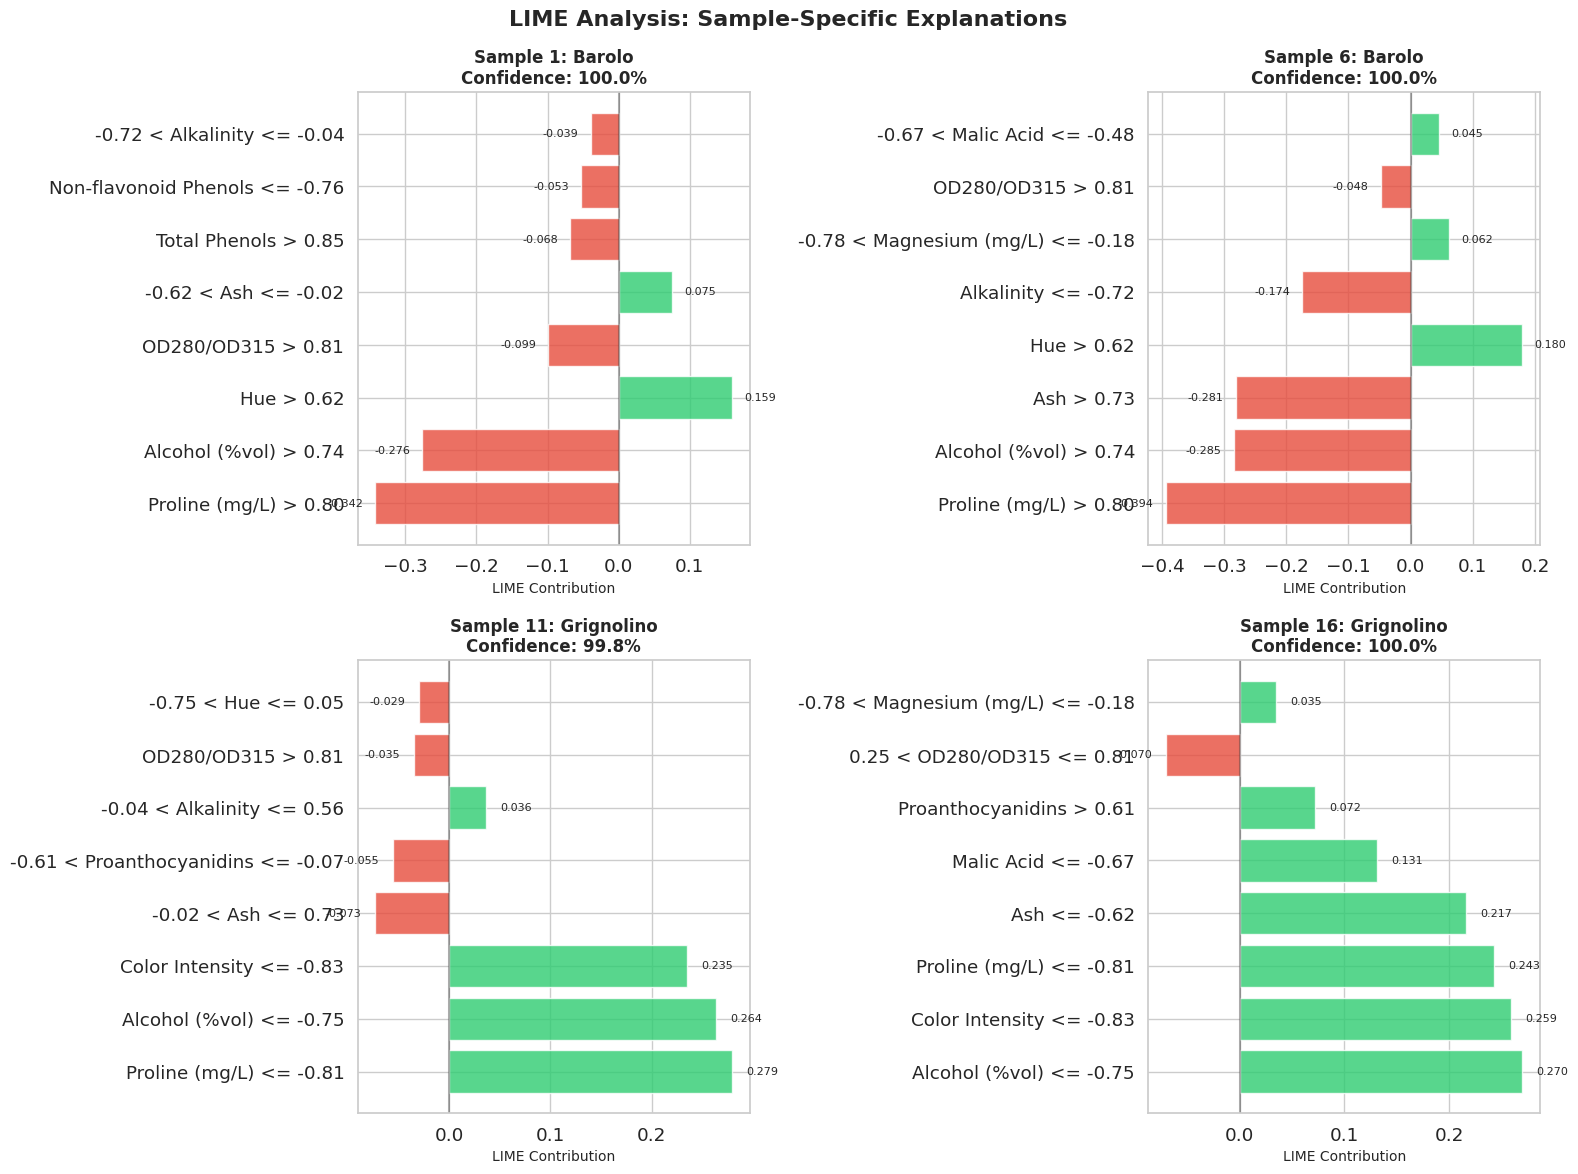


COMPARATIVE ANALYSIS OF LOCAL EXPLANATIONS:
MOST CONSISTENTLY IMPORTANT VARIABLES (LIME):
   1. Proline (mg/L): 0.3117 (average)
   2. Color Intensity: 0.2932 (average)
   3. Alcohol (%vol): 0.2771 (average)
   4. Ash: 0.2576 (average)
   5. Alkalinity: 0.1961 (average)

SPECIAL CASES DETECTED:
   • 1 samples with confidence <70%
   • These require detailed LIME inspection to understand uncertainty


In [82]:
# @title
def lime_analysis_wine():
    """LIME analysis for specific local explanations"""

    print("\nLIME ANALYSIS: Detailed Local Explanations")
    print("=" * 55)

    # Create LIME explainer
    explainer = LimeTabularExplainer(
        X_train_scaled,
        feature_names=variable_names,
        class_names=["Barolo", "Grignolino", "Barbera"],
        mode="classification",
        discretize_continuous=True,
    )

    # Analyze specific samples
    selected_samples = [0, 5, 10, 15]

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, sample_idx in enumerate(selected_samples):
        # Get LIME explanation
        exp = explainer.explain_instance(
            X_test_scaled[sample_idx], model_wrapper, num_features=8, num_samples=1000
        )

        # Extract explanation data
        feature_importance = exp.as_list()
        lime_names = [item[0] for item in feature_importance]
        lime_values = [item[1] for item in feature_importance]

        # Get prediction
        real_pred = model_wrapper(X_test_scaled[sample_idx : sample_idx + 1])[0]
        predicted_class = np.argmax(real_pred)
        confidence = real_pred[predicted_class] * 100

        # Plot explanation
        ax = axes[idx]
        lime_colors = [
            project_colors["green"] if v > 0 else project_colors["red"]
            for v in lime_values
        ]

        bars = ax.barh(lime_names, lime_values, color=lime_colors, alpha=0.8)
        ax.set_title(
            f"Sample {sample_idx + 1}: {['Barolo', 'Grignolino', 'Barbera'][predicted_class]}\n"
            f"Confidence: {confidence:.1f}%",
            fontsize=12,
            fontweight="bold",
        )
        ax.set_xlabel("LIME Contribution", fontsize=10)
        ax.axvline(x=0, color="black", linestyle="-", alpha=0.3)

        for bar, value in zip(bars, lime_values):
            width = bar.get_width()
            ax.text(
                width
                + np.sign(width)
                * max(abs(max(lime_values)), abs(min(lime_values)))
                * 0.05,
                bar.get_y() + bar.get_height() / 2,
                f"{value:.3f}",
                ha="left" if width > 0 else "right",
                va="center",
                fontsize=8,
            )

    plt.suptitle(
        "LIME Analysis: Sample-Specific Explanations", fontsize=16, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

    # Comparative analysis
    print("\nCOMPARATIVE ANALYSIS OF LOCAL EXPLANATIONS:")
    print("=" * 55)

    all_explanations = []
    for sample_idx in range(min(20, len(X_test_scaled))):
        exp = explainer.explain_instance(
            X_test_scaled[sample_idx], model_wrapper, num_features=len(variable_names)
        )
        all_explanations.append(exp.as_list())

    # Count consistently important features
    variable_counter = {}
    for exp in all_explanations:
        for feature, importance in exp:
            base_feature = feature.split("<=")[0].split(">")[0].strip()
            if base_feature not in variable_counter:
                variable_counter[base_feature] = []
            variable_counter[base_feature].append(abs(importance))

    consistent_importance = {
        var: np.mean(vals) for var, vals in variable_counter.items()
    }
    top_consistent = sorted(
        consistent_importance.items(), key=lambda x: x[1], reverse=True
    )[:5]

    print("MOST CONSISTENTLY IMPORTANT VARIABLES (LIME):")
    for i, (var, importance) in enumerate(top_consistent):
        print(f"   {i + 1}. {var}: {importance:.4f} (average)")

    print(f"\nSPECIAL CASES DETECTED:")
    low_confidence = []
    for sample_idx in range(len(X_test_scaled)):
        pred = model_wrapper(X_test_scaled[sample_idx : sample_idx + 1])[0]
        max_conf = np.max(pred)
        if max_conf < 0.7:
            low_confidence.append((sample_idx, max_conf))

    if low_confidence:
        print(f"   • {len(low_confidence)} samples with confidence <70%")
        print("   • These require detailed LIME inspection to understand uncertainty")
    else:
        print("   • All samples have high confidence (>70%)")

    return explainer


# Run LIME analysis
lime_explainer = lime_analysis_wine()


COMPARISON: SHAP vs LIME


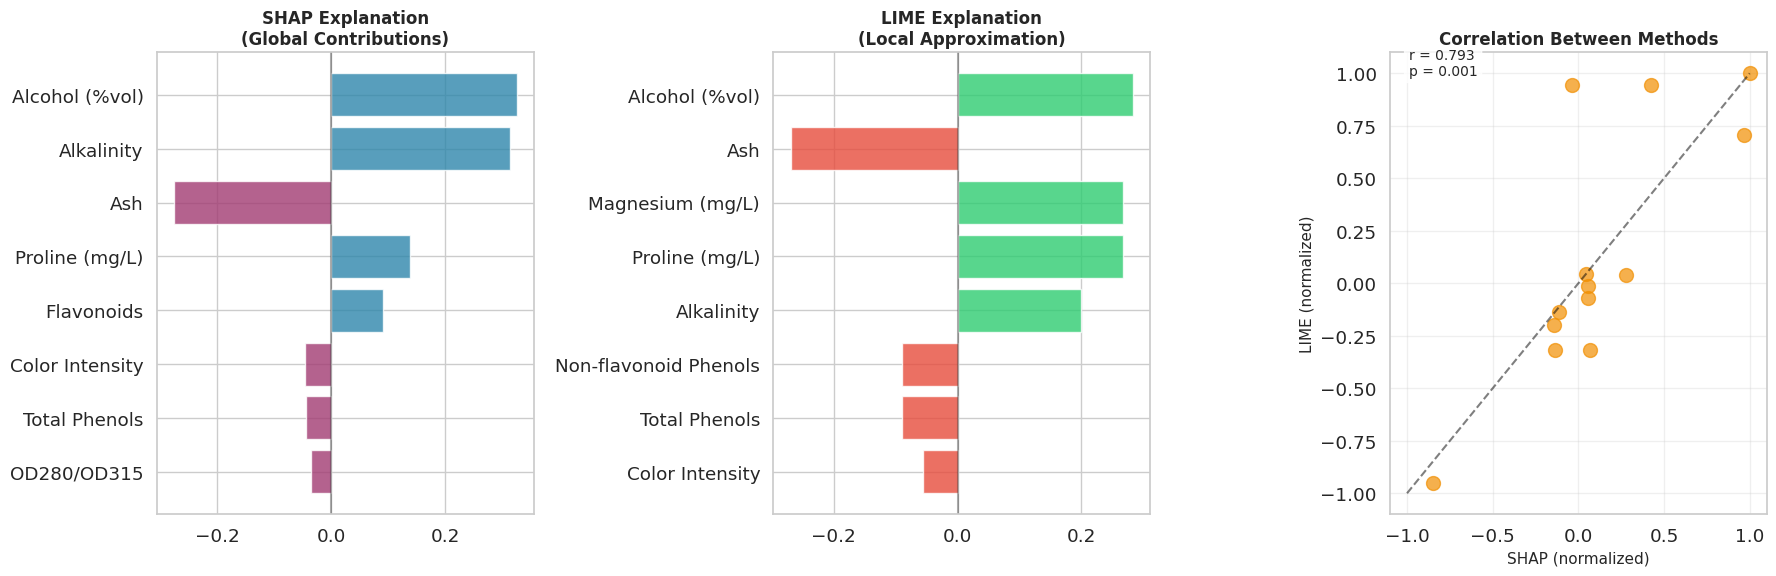

SAMPLE ANALYSIS 4:
   • Predicted as: Grignolino
   • SHAP-LIME Correlation: r = 0.793

KEY DIFFERENCES:
   SHAP:
     • Mathematically grounded and consistent values
     • Same relative importance across similar samples
     • Better suited for global model understanding
   LIME:
     • Instance-specific explanations
     • Can vary across similar samples
     • Better suited to justify individual decisions

RECOMMENDATION FOR CHEMISTRY:
   • High agreement → Both methods are reliable
   • Use SHAP for general insights, LIME for individual samples


In [83]:
# @title
def compare_shap_vs_lime():
    """Direct comparison between SHAP and LIME explanations"""

    print("\nCOMPARISON: SHAP vs LIME")
    print("=" * 40)

    # Select one sample for direct comparison
    example_sample = 3

    # SHAP explanation
    shap_sample = shap_values[example_sample]
    predicted_class = np.argmax(
        model_wrapper(X_test_scaled[example_sample : example_sample + 1])[0]
    )
    shap_vals = shap_sample.values[:, predicted_class]

    # LIME explanation
    exp_lime = lime_explainer.explain_instance(
        X_test_scaled[example_sample], model_wrapper, num_features=len(variable_names)
    )

    # Extract LIME values in the same order as SHAP
    lime_dict = dict(exp_lime.as_list())
    lime_vals = []
    for name in variable_names:
        lime_val = 0
        for key_lime, val_lime in lime_dict.items():
            if any(word in key_lime for word in name.split()[:2]):
                lime_val = val_lime
                break
        lime_vals.append(lime_val)

    # Visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # SHAP
    shap_indices = np.argsort(np.abs(shap_vals))[-8:]
    shap_names = [variable_names[i] for i in shap_indices]
    shap_top_vals = [shap_vals[i] for i in shap_indices]
    shap_colors = [
        project_colors["blue"] if v > 0 else project_colors["purple"]
        for v in shap_top_vals
    ]

    ax1.barh(shap_names, shap_top_vals, color=shap_colors, alpha=0.8)
    ax1.set_title(
        "SHAP Explanation\n(Global Contributions)", fontsize=12, fontweight="bold"
    )
    ax1.axvline(x=0, color="black", linestyle="-", alpha=0.3)

    # LIME
    lime_indices = np.argsort(np.abs(lime_vals))[-8:]
    lime_names = [variable_names[i] for i in lime_indices]
    lime_top_vals = [lime_vals[i] for i in lime_indices]
    lime_colors = [
        project_colors["green"] if v > 0 else project_colors["red"]
        for v in lime_top_vals
    ]

    ax2.barh(lime_names, lime_top_vals, color=lime_colors, alpha=0.8)
    ax2.set_title(
        "LIME Explanation\n(Local Approximation)", fontsize=12, fontweight="bold"
    )
    ax2.axvline(x=0, color="black", linestyle="-", alpha=0.3)

    # Correlation plot between methods
    shap_norm = shap_vals / (np.max(np.abs(shap_vals)) + 1e-8)
    lime_norm = np.array(lime_vals) / (np.max(np.abs(lime_vals)) + 1e-8)

    ax3.scatter(shap_norm, lime_norm, c=project_colors["orange"], s=100, alpha=0.7)
    ax3.plot([-1, 1], [-1, 1], "k--", alpha=0.5)
    ax3.set_xlabel("SHAP (normalized)", fontsize=11)
    ax3.set_ylabel("LIME (normalized)", fontsize=11)
    ax3.set_title("Correlation Between Methods", fontsize=12, fontweight="bold")
    ax3.grid(True, alpha=0.3)

    # Compute correlation
    from scipy.stats import pearsonr

    correlation, p_value = pearsonr(shap_norm, lime_norm)
    ax3.text(
        0.05,
        0.95,
        f"r = {correlation:.3f}\np = {p_value:.3f}",
        transform=ax3.transAxes,
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

    # Textual analysis
    print(f"SAMPLE ANALYSIS {example_sample + 1}:")
    print(f"   • Predicted as: {['Barolo', 'Grignolino', 'Barbera'][predicted_class]}")
    print(f"   • SHAP-LIME Correlation: r = {correlation:.3f}")

    print(f"\nKEY DIFFERENCES:")
    print("   SHAP:")
    print("     • Mathematically grounded and consistent values")
    print("     • Same relative importance across similar samples")
    print("     • Better suited for global model understanding")

    print("   LIME:")
    print("     • Instance-specific explanations")
    print("     • Can vary across similar samples")
    print("     • Better suited to justify individual decisions")

    print(f"\nRECOMMENDATION FOR CHEMISTRY:")
    if correlation > 0.7:
        print("   • High agreement → Both methods are reliable")
        print("   • Use SHAP for general insights, LIME for individual samples")
    elif correlation > 0.3:
        print("   • Moderate agreement → Use both methods complementarily")
        print("   • Investigate discrepancies for deeper insights")
    else:
        print("   • Low agreement → Reassess data and model quality")
        print("   • The model may be learning noise instead of meaningful signal")


# Run comparison
compare_shap_vs_lime()